<a href="https://colab.research.google.com/github/HuLilyowo/Treatment_Discontinuation/blob/main/Treatment_discontinuation_(TAMU_Humana).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Drive

In [ ]:
# ! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import shap

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import StratifiedKFold ## recommended for classification

from sklearn.metrics import r2_score, accuracy_score
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn import tree

np.set_printoptions(formatter={'float': lambda x: "{0:0.4f}".format(x)})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('drive/Shared drives/*****')

# Import Data

In [ ]:
target_train = pd.read_csv('data/target_train.csv')
target_test = pd.read_csv('data/target_holdout.csv')
med_train = pd.read_csv('data/medclms_train.csv')
med_test = pd.read_csv('data/medclms_holdout.csv')
rx_train = pd.read_csv('data/rxclms_train.csv')
rx_test = pd.read_csv('data/rxclms_holdout.csv')

In [ ]:
# change the datatype of date (to datetime)
def date_col(df):
    date_columns = df.filter(like='date')
    df[date_columns.columns] = date_columns.apply(pd.to_datetime)\
    .apply(lambda x: x.dt.tz_localize(None))

date_col(target_train)
date_col(target_test)
date_col(med_train)
date_col(med_test)
date_col(rx_train)
date_col(rx_test)

# Data Cleansing

## med_train

In [ ]:
# keep copys of the datasets

med_train_c = med_train.copy()
med_test_c = med_test.copy()

### Exploration

In [1]:
# med_train.head()

In [2]:
# med_train.dtypes

In [3]:
# med_train.shape

In [4]:
# med_train.nunique(dropna = False)

In [5]:
# med_train.isna().sum()

# # diag_cd is non-primary diagnosis codes for a medical claim.
# # Not necessary to be exist in a claim, I'll not fill the missing value but use the columns to encode features.

In [6]:
# find the unique values for a specific feature in both train and test sets

def print_unique(colname):
  print(colname + ": ")
  print(med_train[colname].unique())
  print(med_test[colname].unique(), end="\n\n")

# print_unique("reversal_ind")
# print_unique("pot")
# print_unique("util_cat")
# print_unique("hedis_pot")

In [7]:
# med_train_c.groupby(["therapy_id", "clm_unique_key"]).nunique().mean()

# # The results of pot (position) & HEDIS are over 1
# # We believe it is not common for a single claim to have multiple positions and HEDIS related to it

### Remove duplicates

In [ ]:
# Replace "Unknown" values with NaN first.
# We will drop some of them so we need to sort them to bottom.

med_train_c["pot"] = med_train_c["pot"].replace(to_replace=r'Unknown', value=np.nan)
med_train_c["hedis_pot"] = med_train_c["hedis_pot"].replace(to_replace=r'Other', value=np.nan)

In [9]:
# count how many diagnosis code is missing
med_train_c["diag_count_NA"] = (med_train_c["primary_diag_cd"].isna().astype(int)
+ med_train_c["diag_cd2"].isna().astype(int)
+ med_train_c["diag_cd3"].isna().astype(int)
+ med_train_c["diag_cd4"].isna().astype(int)
+ med_train_c["diag_cd5"].isna().astype(int)
+ med_train_c["diag_cd6"].isna().astype(int)
+ med_train_c["diag_cd7"].isna().astype(int)
+ med_train_c["diag_cd8"].isna().astype(int)
+ med_train_c["diag_cd9"].isna().astype(int))

# med_train_c["diag_count_NA"]

In [ ]:
# drop duplicates
med_train_c = (med_train_c
               .sort_values(["therapy_id", "clm_unique_key", "primary_diag_cd", "diag_count_NA", "visit_date", "pot","util_cat", "hedis_pot"])
               .groupby(["therapy_id", "clm_unique_key", "primary_diag_cd"]).head(1))

###  reversal_ind: NaN and "No"

In [10]:
# get dummy for reversal_ind
# 0 = nan; 1 = No (the field only has nan and 0, a bit confusing though)
med_train_c['reversal_dum'] = pd.get_dummies(med_train_c['reversal_ind'])
med_test_c['reversal_dum'] = pd.get_dummies(med_test_c['reversal_ind'])

# med_train_c['reversal_dum']

In [ ]:
# we use reversal_dum to represent reversal_ind already, we don't need reversal_ind anymore
med_train_c = med_train_c.drop(columns = 'reversal_ind')
med_test_c = med_test_c.drop(columns = 'reversal_ind')

### util_cat and pot: fill with "Unknown"

util_cat is Combination of admit_type and pot for use in creating utilization categories. All the nan in the 'pot' have unknown in the 'util_cat'. Filling all the nan with 'Unknown' for now.

In [37]:
# med_train_c.groupby(['util_cat', 'pot'], dropna=False).size()

In [ ]:
med_train_c['pot'].fillna('Unknown', inplace = True)
med_test_c['pot'].fillna('Unknown', inplace = True)

med_train_c['util_cat'].fillna('Unknown', inplace = True)
med_test_c['util_cat'].fillna('Unknown', inplace = True)

med_train_c['hedis_pot'].fillna('Other', inplace = True)
med_test_c['hedis_pot'].fillna('Other', inplace = True)

## rx_train

In [ ]:
# keep copys of the datasets

rx_train_c = rx_train.copy()
rx_test_c = rx_test.copy()

### exploration

In [11]:
# rx_train.head()

In [12]:
# rx_train.dtypes

In [13]:
# rx_train.shape

In [14]:
# rx_train.nunique(dropna = False)

In [15]:
# rx_train.isna().sum()

### change datatype for some columns

In [16]:
# print all unique values in a field
def print_unique(colname):
  print(colname + ": ")
  print(rx_train[colname].unique())
  print(rx_test[colname].unique(), end="\n\n")

# print_unique("reversal_ind")
# print_unique("mail_order_ind")
# print_unique("generic_ind")
# print_unique("maint_ind")
# print_unique("specialty_ind")
# print_unique("ddi_ind")
# print_unique("anticoag_ind")
# print_unique("diarrhea_treat_ind")
# print_unique("nausea_treat_ind")
# print_unique("seizure_treat_ind")

In [ ]:
# create dummies

# mail_order_ind: Y = 1, N = 0
rx_train_c['mail_order_ind'] = rx_train_c['mail_order_ind'].apply(lambda x: 1 if x == 'Y' else 0)
# generic_ind: BRANDED = 1, GENERIC = 0
rx_train_c['generic_ind'] = rx_train_c['generic_ind'].apply(lambda x: 1 if x == 'BRANDED' else 0)
# maint_ind: MAINT = 1, NONMAINT = 0
rx_train_c['maint_ind'] = rx_train_c['maint_ind'].apply(lambda x: 1 if x == 'MAINT' else 0)
# specialty_ind: SPCL = 1, NONSPCL = 0
rx_train_c['specialty_ind'] = rx_train_c['specialty_ind'].apply(lambda x: 1 if x == 'SPCL' else 0)

# mail_order_ind: Y = 1, N = 0
rx_test_c['mail_order_ind'] = rx_test_c['mail_order_ind'].apply(lambda x: 1 if x == 'Y' else 0)
# generic_ind: BRANDED = 1, GENERIC = 0
rx_test_c['generic_ind'] = rx_test_c['generic_ind'].apply(lambda x: 1 if x == 'BRANDED' else 0)
# maint_ind: MAINT = 1, NONMAINT = 0
rx_test_c['maint_ind'] = rx_test_c['maint_ind'].apply(lambda x: 1 if x == 'MAINT' else 0)
# specialty_ind: SPCL = 1, NONSPCL = 0
rx_test_c['specialty_ind'] = rx_test_c['specialty_ind'].apply(lambda x: 1 if x == 'SPCL' else 0)


### 1. gpi_drug_group_desc, gpi_drug_class_desc, hum_drug_class_desc: with "SUPPILES" and "UNKNOWN"

In [17]:
missing_gpi = rx_train.loc[rx_train['gpi_drug_group_desc'].isna(),:].copy()
# missing_gpi.groupby(['gpi_drug_group_desc', 'gpi_drug_class_desc', 'hum_drug_class_desc'], dropna=False).size()

In [18]:
# missing_gpi[missing_gpi['ndc_id'].astype(str).str.startswith('11111') == False]

# # I have no idea what those start with 11111 means
# # only 2 records of the missing 'gpi_drug_group_desc' are not start with 11111

# # the ndc_id of those two (28465004502) is a pen needle (for diabetics) product
# # I'll label their gpi_drug_group: *MEDICAL DEVICES AND SUPPLIES*;
# # gpi_drug_class: *DIABETIC SUPPLIES**; hum_drug_class: DIABETIC SUPPLIES

In [19]:
rx_train_c.loc[rx_train_c['ndc_id'] == 28465004502,'gpi_drug_group_desc'] = '*MEDICAL DEVICES AND SUPPLIES*'
rx_train_c.loc[rx_train_c['ndc_id'] == 28465004502,'gpi_drug_class_desc'] = '*DIABETIC SUPPLIES**'
rx_train_c.loc[rx_train_c['ndc_id'] == 28465004502,'hum_drug_class_desc'] = 'DIABETIC SUPPLIES'

rx_test_c.loc[rx_test_c['ndc_id'] == 28465004502,'gpi_drug_group_desc'] = '*MEDICAL DEVICES AND SUPPLIES*'
rx_test_c.loc[rx_test_c['ndc_id'] == 28465004502,'gpi_drug_class_desc'] = '*DIABETIC SUPPLIES**'
rx_test_c.loc[rx_test_c['ndc_id'] == 28465004502,'hum_drug_class_desc'] = 'DIABETIC SUPPLIES'

# rx_train_c[rx_train_c['ndc_id'] == 28465004502].iloc[:,0:-6]

In [ ]:
### for those ndc_id start with '11111', I'll just label them as Unknown so far.
rx_train_c.loc[rx_train_c['gpi_drug_group_desc'].isna(),'gpi_drug_group_desc'] = '*UNKNOWN*'
rx_train_c.loc[rx_train_c['gpi_drug_class_desc'].isna(),'gpi_drug_class_desc'] = '*UNKNOWN**'
rx_train_c.loc[rx_train_c['hum_drug_class_desc'].isna(),'hum_drug_class_desc'] = 'UNKNOWN'

### for those ndc_id start with '11111', I'll just label them as Unknown so far.
rx_test_c.loc[rx_test_c['gpi_drug_group_desc'].isna(),'gpi_drug_group_desc'] = '*UNKNOWN*'
rx_test_c.loc[rx_test_c['gpi_drug_class_desc'].isna(),'gpi_drug_class_desc'] = '*UNKNOWN**'
rx_test_c.loc[rx_test_c['hum_drug_class_desc'].isna(),'hum_drug_class_desc'] = 'UNKNOWN'

### strength_meas and metric_strength:

We planned to use mean and mode to fill in the missing value, but that might cause data leakage. Data leakage might not cause a big issue here but just in case it would introduce some bias, we decided to leave every missing value as 'Unknown' and 0.

In [20]:
# rx_train.groupby(['strength_meas', 'metric_strength'], dropna=False).size()

In [21]:
# # count how many of the records of each gpi_drug_class are both NaN for strength_meas and metric_strength
# # (gpi_drug_group and hum_drug_class are higher hierarchies)

# (rx_train_c.loc[((rx_train_c['strength_meas'].isna()) | (rx_train_c['metric_strength'].isna()))]
#  .groupby(['gpi_drug_group_desc', 'gpi_drug_class_desc','hum_drug_class_desc','strength_meas','metric_strength'], dropna=False)
#  .agg(["size"])["therapy_id"])

In [ ]:
# target_class = ['DIABETIC SUPPLIES','TEST SUPPLIES', 'PRODUCTS/ SUPPLIES','COUGH/ COLD/ ALLERGY']

# for i in target_class:
#   print(i,':', test[test['hum_drug_class_desc'] == i].shape[0]/rx_train_c[rx_train_c['hum_drug_class_desc'] == i].shape[0])

# target_group = ['*MEDICAL DEVICES AND SUPPLIES*', '*DIAGNOSTIC PRODUCTS*']

# for i in target_group:
#   print(i,'-',test[test['gpi_drug_group_desc'] == i].shape[0]/rx_train_c[rx_train_c['gpi_drug_group_desc'] == i].shape[0])

In [ ]:
# # for 'PRODUCTS/ SUPPLIES' and 'COUGH/ COLD/ ALLERGY', we can use mean/mode of hum_drug_class_desc
# # for 'DIABETIC SUPPLIES' and 'TEST SUPPLIES', we may need to use the group
# # diganostic products is hopeless, let's do it as Unknown

# # strengthh_meas
# str_prod_mode = rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'PRODUCTS/ SUPPLIES') &
#                 (rx_train_c['strength_meas'].notna()),'strength_meas'].mode()[0]
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'PRODUCTS/ SUPPLIES') &
#                 (rx_train_c['strength_meas'].isna()),'strength_meas'] = str_prod_mode
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'PRODUCTS/ SUPPLIES') &
#                 (rx_test_c['strength_meas'].isna()),'strength_meas'] = str_prod_mode


# str_cough_mode = rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'COUGH/ COLD/ ALLERGY') &
#                 (rx_train_c['strength_meas'].notna()),'strength_meas'].mode()[0]
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'COUGH/ COLD/ ALLERGY') &
#                 (rx_train_c['strength_meas'].isna()),'strength_meas'] = str_cough_mode
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'COUGH/ COLD/ ALLERGY') &
#                 (rx_test_c['strength_meas'].isna()),'strength_meas'] = str_cough_mode


# str_supplies_mode = rx_train_c.loc[(rx_train_c['gpi_drug_group_desc'] == '*MEDICAL DEVICES AND SUPPLIES*') &
#                  (rx_train_c['strength_meas'].notna()),'strength_meas'].mode()[0]
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'DIABETIC SUPPLIES') &
#                 (rx_train_c['strength_meas'].isna()),'strength_meas'] = str_supplies_mode
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'DIABETIC SUPPLIES') &
#                 (rx_test_c['strength_meas'].isna()),'strength_meas'] = str_supplies_mode


# str_test_mode = rx_train_c.loc[(rx_train_c['gpi_drug_group_desc'] == '*DIAGNOSTIC PRODUCTS*') &
#                  (rx_train_c['strength_meas'].notna()),'strength_meas'].mode()[0]
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'TEST SUPPLIES') &
#                 (rx_train_c['strength_meas'].isna()),'strength_meas'] = str_test_mode
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'TEST SUPPLIES') &
#                 (rx_test_c['strength_meas'].isna()),'strength_meas'] = str_test_mode

In [ ]:
# # metric_strength
# metric_str_prod_mean = rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'PRODUCTS/ SUPPLIES') &
#                         (rx_train_c['metric_strength'].notna()),'metric_strength'].mean()
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'PRODUCTS/ SUPPLIES') &
#                 (rx_train_c['metric_strength'].isna()),'metric_strength'] = metric_str_prod_mean
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'PRODUCTS/ SUPPLIES') &
#                 (rx_test_c['metric_strength'].isna()),'metric_strength'] = metric_str_prod_mean


# metric_str_cough_mean = rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'COUGH/ COLD/ ALLERGY') &
#                         (rx_train_c['metric_strength'].notna()),'metric_strength'].mean()
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'COUGH/ COLD/ ALLERGY') &
#                 (rx_train_c['metric_strength'].isna()),'metric_strength'] = metric_str_cough_mean
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'COUGH/ COLD/ ALLERGY') &
#                 (rx_test_c['metric_strength'].isna()),'metric_strength'] = metric_str_cough_mean


# metric_str_supplies_mean = rx_train_c.loc[(rx_train_c['gpi_drug_group_desc'] == '*MEDICAL DEVICES AND SUPPLIES*') &
#                  (rx_train_c['metric_strength'].notna()),'metric_strength'].mean()
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'DIABETIC SUPPLIES') &
#                 (rx_train_c['metric_strength'].isna()),'metric_strength'] = metric_str_supplies_mean
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'DIABETIC SUPPLIES') &
#                 (rx_test_c['metric_strength'].isna()),'metric_strength'] = metric_str_supplies_mean


# metric_str_test_mean = rx_train_c.loc[(rx_train_c['gpi_drug_group_desc'] == '*DIAGNOSTIC PRODUCTS*') &
#                  (rx_train_c['metric_strength'].notna()),'metric_strength'].mean()
# rx_train_c.loc[(rx_train_c['hum_drug_class_desc'] == 'TEST SUPPLIES') &
#                 (rx_train_c['metric_strength'].isna()),'metric_strength'] = metric_str_test_mean
# rx_test_c.loc[(rx_test_c['hum_drug_class_desc'] == 'TEST SUPPLIES') &
#                 (rx_test_c['metric_strength'].isna()),'metric_strength'] = metric_str_test_mean

In [ ]:
rx_train_c.loc[rx_train_c['strength_meas'].isna(),'strength_meas'] = 'Unknown'
rx_train_c.loc[rx_train_c['metric_strength'].isna(),'metric_strength'] = 0

rx_test_c.loc[rx_test_c['strength_meas'].isna(),'strength_meas'] = 'Unknown'
rx_test_c.loc[rx_test_c['metric_strength'].isna(),'metric_strength'] = 0

# rx_train_c.loc[rx_train_c['metric_strength'].isna(),'metric_strength'] = rx_train_c['metric_strength'].median()

## target_train

In [ ]:
target_train_c = target_train.copy()
target_test_c = target_test.copy()

### exploration

In [22]:
# target_train.nunique()

In [23]:
# target_train.isna().sum()

### data cleansing

In [ ]:
# create col to label original null value
list_fill = ['est_age','cms_disabled_ind','cms_low_income_ind']
for col in list_fill:
    col_name = col + '_NAornot'
    target_train_c[col_name] = target_train_c[col].apply(lambda x: 1 if pd.isna(x) else 0)
    target_test_c[col_name] = target_test_c[col].apply(lambda x: 1 if pd.isna(x) else 0)

In [ ]:
# fillin the missing values
# target_train_c.loc[target_train_c['race_cd'].isna(),'race_cd'] = target_train_c['race_cd'].mode()[0]
target_train_c.loc[target_train_c['est_age'].isna(),'est_age'] = target_train_c['est_age'].mean()
# target_test_c.loc[target_test_c['race_cd'].isna(),'race_cd'] = target_train_c['race_cd'].mode()[0] # Use Train
target_test_c.loc[target_test_c['est_age'].isna(),'est_age'] = target_train_c['est_age'].mean() # Use Train

# # sex_cd: male = 0, female = 1
# target_train_c.loc[target_train_c['sex_cd'] == 'M','sex_cd'] = 0
# target_train_c.loc[target_train_c['sex_cd'] == 'F','sex_cd'] = 1
# target_train_c.loc[target_train_c['sex_cd'].isna(),'sex_cd'] = target_train_c['sex_cd'].mode()[0]
# target_test_c.loc[target_test_c['sex_cd'] == 'M','sex_cd'] = 0
# target_test_c.loc[target_test_c['sex_cd'] == 'F','sex_cd'] = 1
# target_test_c.loc[target_test_c['sex_cd'].isna(),'sex_cd'] = target_train_c['sex_cd'].mode()[0] # Use Train

target_train_c.loc[target_train_c['cms_disabled_ind'].isna(),'cms_disabled_ind'] = target_train_c['cms_disabled_ind'].mode()[0]
target_train_c.loc[target_train_c['cms_low_income_ind'].isna(),'cms_low_income_ind'] = target_train_c['cms_low_income_ind'].mode()[0]
target_test_c.loc[target_test_c['cms_disabled_ind'].isna(),'cms_disabled_ind'] = target_train_c['cms_disabled_ind'].mode()[0] # Use Train
target_test_c.loc[target_test_c['cms_low_income_ind'].isna(),'cms_low_income_ind'] = target_train_c['cms_low_income_ind'].mode()[0] # Use Train


In [24]:
# target_train_c.isna().sum()

# Feature Engineering

## Prep


In [26]:
target_train_cc = target_train_c.copy()
# print(target_train_cc.shape)

target_test_cc = target_test_c.copy()
# print(target_test_cc.shape)

# print(target_train_cc.isna().sum().sum())
# print(target_test_cc.isna().sum().sum())

target_train_c.set_index('therapy_id', inplace = True)
target_test_c.set_index('therapy_id', inplace = True)

In [ ]:
before_var_list = set()
after_var_list = set()
all_var_list = set()

In [ ]:
# # NDC code for TAGRISSO 0310-1349-30, 0310-1350-30, 0310-1350-95

# # I want to put everytime they get TAGRISSO as the anchor,
# # and calculate how many days between they get TAGRISSO and other drugs
# # there are claims for everyone before their first claim on TAGRISSO
# # maybe set those days as negative numbers (wait, we need to aggregate the numbers, should I leave them as 0???)

# # Feature 1: How long for each patient start a new claim after their closest claim for TAGRISSO
# rx_merge = pd.DataFrame()
# anchor_ndc_ids = [310134930, 310135030, 310135095]
# rx_train_c['Anchor'] = rx_train_c['ndc_id'].isin(anchor_ndc_ids).astype(int)

# # therapy = list(rx_train_c['therapy_id'].unique())
# # for id in therapy:
# #   print(id)
# #   df = rx_train_c[rx_train_c['therapy_id'] == id].reset_index()
# #   try:
# #     first_tagr = df[df['Anchor'] == 1].index[0]
# #   except:
#      # there are some therapy_id without ordering TAGRISSO

## target_train_cc

In [ ]:
target_train_cc["therapy_length"] = (target_train_cc["therapy_end_date"] - target_train_cc["therapy_start_date"]).dt.days

target_train_cc["tgt_ade_dc_ind_30"] = ((target_train_cc["therapy_length"] <= 30) & (target_train_cc["tgt_ade_dc_ind"] == 1)).astype(int)
target_train_cc["tgt_ade_dc_ind_60"] = ((target_train_cc["therapy_length"] <= 60) & (target_train_cc["tgt_ade_dc_ind"] == 1)).astype(int)
target_train_cc["tgt_ade_dc_ind_90"] = ((target_train_cc["therapy_length"] <= 90) & (target_train_cc["tgt_ade_dc_ind"] == 1)).astype(int)

target_train_07d = target_train_cc.copy()
target_train_15d = target_train_cc.copy()
target_train_30d = target_train_cc.copy()
target_train_60d = target_train_cc.copy()

## med_train_c

###Prepare before after flag

In [29]:
med_train_c.set_index('therapy_id', inplace = True)
med_test_c.set_index('therapy_id', inplace = True)

In [30]:
med_train_c['therapy_start_date'] = target_train_c['therapy_start_date']
med_test_c['therapy_start_date'] = target_test_c['therapy_start_date']

In [32]:
# I want to have a helper to label whether a claim is before or after the therapy_start_date
# drop it before feature selection
# before the therapy_start_date = 0, after the therapy_start_date = 1
# therapy_id nunique = 536 from med_train

med_train_c['helper_boa'] = med_train_c.apply(
    lambda x: 1 if x['therapy_start_date'] <= x['visit_date'] else 0, axis=1)
med_test_c['helper_boa'] = med_test_c.apply(
    lambda x: 1 if x['therapy_start_date'] <= x['visit_date'] else 0, axis=1)

med_train_07d = med_train_c[(med_train_c["visit_date"] - med_train_c["therapy_start_date"]).dt.days <= 7]
med_train_15d = med_train_c[(med_train_c["visit_date"] - med_train_c["therapy_start_date"]).dt.days <= 15]
med_train_30d = med_train_c[(med_train_c["visit_date"] - med_train_c["therapy_start_date"]).dt.days <= 30]
med_train_60d = med_train_c[(med_train_c["visit_date"] - med_train_c["therapy_start_date"]).dt.days <= 60]

In [31]:
def med_apply_func(function):

    global target_train_cc, target_train_07d, target_train_15d, target_train_30d, target_train_60d
    global target_test_cc
    global med_train_c, med_train_07d, med_train_15d, med_train_30d, med_train_60d
    global med_test_c

    try:
        target_train_cc = function(target_train_cc, med_train_c)
        target_train_07d = function(target_train_07d, med_train_07d)
        target_train_15d = function(target_train_15d, med_train_15d)
        target_train_30d = function(target_train_30d, med_train_30d)
        target_train_60d = function(target_train_60d, med_train_60d)
        target_test_cc = function(target_test_cc, med_test_c)

    except:
        target_train_cc = function(target_train_cc)
        target_train_07d = function(target_train_07d)
        target_train_15d = function(target_train_15d)
        target_train_30d = function(target_train_30d)
        target_train_60d = function(target_train_60d)
        target_test_cc = function(target_test_cc)

### feature: med_count (Counts of med_claims before/after/all)

In [ ]:
# feature: num of med_claims before/after/all therapy_start_date

def med_count(target_df, med_df):

    bef_count = med_df[med_df['helper_boa'] == 0].groupby('therapy_id').size().reset_index(name='med_bef_count')
    af_count = med_df[med_df['helper_boa'] == 1].groupby('therapy_id').size().reset_index(name='med_af_count')
    all_count = med_df.groupby('therapy_id').size().reset_index(name='med_all_count')

    feature_list = [all_count,bef_count,af_count]

    for f in feature_list:
        target_df = target_df.merge(f, left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]  # Get the name of the last column
        # target_df[last_col + "_NA"] = target_df[last_col].isna()
        try:
          target_df[last_col] = target_df[last_col].fillna(0) # Use train
        except:
          target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

    before_var_list.add('med_bef_count')
    after_var_list.add('med_af_count')
    all_var_list.add('med_all_count')

    # I don't need NA flag. It should just be 0.
    # before_var_list.add('med_bef_count_NA')
    # after_var_list.add('med_af_count_NA')
    # all_var_list.add('med_all_count_NA')

    return target_df.copy()

med_apply_func(med_count)

### feature: med_diag_count (Sum of diagnosis in med_claims before/after/all)

In [ ]:
# feature: num of ADE diagnosis, all, before, and after
list_ade = [col for col in med_train_c.columns if col.endswith('diagnosis')]

def med_diag_count(target_df, med_df):

    for col in list_ade:

        all_name = 'med_all_' + col
        all = med_df[col].groupby('therapy_id').sum().reset_index(name = all_name)
        target_df = target_df.merge(all,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        try:
          target_df[all_name] = target_df[all_name].fillna(0) # Use Zero cuz leakage Not Use train
        except:
          target_df[all_name] = target_df[all_name].fillna(target_df[all_name].mean())

        bef_name = 'med_bef_' + col
        bef = med_df[med_df['helper_boa'] == 0][col].groupby('therapy_id').sum().reset_index(name = bef_name)
        target_df = target_df.merge(bef,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        try:
          target_df[bef_name] = target_df[bef_name].fillna(0)
        except:
          target_df[bef_name] = target_df[bef_name].fillna(target_df[bef_name].mean())

        af_name = 'med_af_' + col
        af = med_df[med_df['helper_boa'] == 1][col].groupby('therapy_id').sum().reset_index(name = af_name)
        target_df = target_df.merge(af,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        try:
          target_df[af_name] = target_df[af_name].fillna(0)
        except:
          target_df[af_name] = target_df[af_name].fillna(target_df[af_name].mean())

        all_var_list.add(all_name)
        before_var_list.add(bef_name)
        after_var_list.add(af_name)

    return target_df.copy()

med_apply_func(med_diag_count)

In [ ]:
before_var_list

{'med_bef_ade_diagnosis',
 'med_bef_constipation_diagnosis',
 'med_bef_count',
 'med_bef_diarrhea_diagnosis',
 'med_bef_fatigue_diagnosis',
 'med_bef_hyperglycemia_diagnosis',
 'med_bef_nausea_diagnosis',
 'med_bef_pain_diagnosis',
 'med_bef_seizure_diagnosis'}

### feature: med_pot_count (Count of "serious/non-serious" place of treatment)

In [ ]:
# # feature: do patients have more serious issue after taking the cancer drug?
# # I'll use pot to check whether the patients need more delicated care
# # not serious = Outpatient, Physician_Office (encode = 0)
# # serious = Inpatient, ER_Facility, Ambulance, ER_Physician, Urgent_Care (encode = 1)
# # Ignore Unknown
# med_train_c['pot_encoding'] = med_train_c['pot'].apply(lambda x: 1 if x in serious_pot else 0)

non_serious_pot = ['Outpatient', 'Physician_Office']
serious_pot = ['Inpatient', 'ER_Facility', 'Ambulance', 'ER_Physician', 'Urgent_Care']

def med_pot_count(target_df, med_df):

    all_serious = med_df[(med_df['pot'].isin(serious_pot))]\
                    .groupby('therapy_id').size().reset_index(name = 'med_all_serious')
    all_non_serious = med_df[(med_df['pot'].isin(non_serious_pot))]\
                    .groupby('therapy_id').size().reset_index(name = 'med_all_non_serious')

    bef_serious = med_df[(med_df['helper_boa'] == 0) & (med_df['pot'].isin(serious_pot))]\
                  .groupby('therapy_id').size().reset_index(name = 'med_bef_serious')
    bef_non_serious = med_df[(med_df['helper_boa'] == 0) & (med_df['pot'].isin(non_serious_pot))]\
                      .groupby('therapy_id').size().reset_index(name = 'med_bef_non_serious')

    af_serious = med_df[(med_df['helper_boa'] == 1) & (med_df['pot'].isin(serious_pot))]\
                .groupby('therapy_id').size().reset_index(name = 'med_af_serious')
    af_non_serious = med_df[(med_df['helper_boa'] == 1) & (med_df['pot'].isin(non_serious_pot))]\
                    .groupby('therapy_id').size().reset_index(name = 'med_af_non_serious')

    var_serious = [all_serious,all_non_serious,bef_serious,bef_non_serious,af_serious,af_non_serious]

    for var in var_serious:
      target_df = target_df.merge(var, left_on = 'therapy_id', right_on = 'therapy_id', how = 'left')
      last_col = target_df.columns[-1]  # Get the name of the last column
      try:
          target_df[last_col].fillna(0, inplace=True)
      except:
          target_df[last_col].fillna(target_df[last_col].mean(), inplace=True)

    all_var_list.add('med_all_serious')
    all_var_list.add('med_all_non_serious')
    before_var_list.add('med_bef_serious')
    before_var_list.add('med_bef_non_serious')
    after_var_list.add('med_af_serious')
    after_var_list.add('med_af_non_serious')

    return target_df.copy()

med_apply_func(med_pot_count)

In [ ]:
before_var_list

{'med_bef_ade_diagnosis',
 'med_bef_constipation_diagnosis',
 'med_bef_count',
 'med_bef_diarrhea_diagnosis',
 'med_bef_fatigue_diagnosis',
 'med_bef_hyperglycemia_diagnosis',
 'med_bef_nausea_diagnosis',
 'med_bef_non_serious',
 'med_bef_pain_diagnosis',
 'med_bef_seizure_diagnosis',
 'med_bef_serious'}

### feature: PDC (The count of Principle Diagnosis Code)

In [34]:
# med_train_c['primary_diag_cd'].str[0:3].value_counts().head(10)

In [33]:
# np.insert(med_train_c['primary_diag_cd'].str[0:1].unique(), 1, ["C34", "C79", "J90"])

In [ ]:
# # feature: ICD_10 (PDC)
# # Principle Diagnosis Code: ICD_10

def med_pdc_count(target_df, med_df):

    pdc_1 = np.insert(med_train_c['primary_diag_cd'].str[0:1].unique(), 1, ["C34", "C79", "J90"]) # add C34 cuz it's special
    pdc_2 = med_train_c['primary_diag_cd'].str[0:2].unique()

    pdc_bucket = [pdc_1, pdc_2]

    for i in range(0,1): # I don't wanna use 2 yet

        for code in pdc_bucket[i]:

            all_name = 'med_all_pdc_count_' + code
            all = med_df['primary_diag_cd'].str.startswith(code).groupby('therapy_id').sum().reset_index(name = all_name)
            target_df = target_df.merge(all,left_on = 'therapy_id', right_on = 'therapy_id', how = 'left')
            try:
              target_df[all_name] = target_df[all_name].fillna(0) # Use Zero cuz leakage Not Use train
            except:
              target_df[all_name] = target_df[all_name].fillna(target_df[all_name].mean())

            bef_name = 'med_bef_pdc_count_' + code
            bef = med_df[med_df['helper_boa'] == 0]['primary_diag_cd'].str.startswith(code).groupby('therapy_id').sum().reset_index(name = bef_name)
            target_df = target_df.merge(bef,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
            try:
              target_df[bef_name] = target_df[bef_name].fillna(0)
            except:
              target_df[bef_name] = target_df[bef_name].fillna(target_df[bef_name].mean())

            af_name = 'med_af_pdc_count_' + code
            af = med_df[med_df['helper_boa'] == 1]['primary_diag_cd'].str.startswith(code).groupby('therapy_id').sum().reset_index(name = af_name)
            target_df = target_df.merge(af,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
            try:
              target_df[af_name] = target_df[af_name].fillna(0)
            except:
              target_df[af_name] = target_df[af_name].fillna(target_df[af_name].mean())

            all_var_list.add(all_name)
            before_var_list.add(bef_name)
            after_var_list.add(af_name)

    return target_df.copy()

med_apply_func(med_pdc_count)

In [ ]:
before_var_list

{'med_bef_ade_diagnosis',
 'med_bef_constipation_diagnosis',
 'med_bef_count',
 'med_bef_diarrhea_diagnosis',
 'med_bef_fatigue_diagnosis',
 'med_bef_hyperglycemia_diagnosis',
 'med_bef_nausea_diagnosis',
 'med_bef_non_serious',
 'med_bef_pain_diagnosis',
 'med_bef_pdc_count_2',
 'med_bef_pdc_count_3',
 'med_bef_pdc_count_A',
 'med_bef_pdc_count_B',
 'med_bef_pdc_count_C',
 'med_bef_pdc_count_C34',
 'med_bef_pdc_count_C79',
 'med_bef_pdc_count_D',
 'med_bef_pdc_count_E',
 'med_bef_pdc_count_F',
 'med_bef_pdc_count_G',
 'med_bef_pdc_count_H',
 'med_bef_pdc_count_I',
 'med_bef_pdc_count_J',
 'med_bef_pdc_count_J90',
 'med_bef_pdc_count_K',
 'med_bef_pdc_count_L',
 'med_bef_pdc_count_M',
 'med_bef_pdc_count_N',
 'med_bef_pdc_count_Q',
 'med_bef_pdc_count_R',
 'med_bef_pdc_count_S',
 'med_bef_pdc_count_T',
 'med_bef_pdc_count_U',
 'med_bef_pdc_count_Z',
 'med_bef_seizure_diagnosis',
 'med_bef_serious'}

###  feature: med_count_ratio (The ratio of the counts between "before/after" and "all")

In [ ]:
# percentage from num claim and ADEs
def med_count_ratio(target_df):

  list_pdc_var = list(["pdc_count_"] + np.insert(med_train_c['primary_diag_cd'].str[0:1].unique(), 1, ["C34", "C79", "J90"]))

  for var in (["count"] + list_ade + ["serious", "non_serious"] + list_pdc_var):

      all_name = 'med_all_' + var # e.g. med_all_ade_diagnosis
      bef_name = 'med_bef_' + var
      af_name = 'med_af_' + var

      all_var = target_df.loc[:, all_name] # all
      bef_var = target_df.loc[:,  bef_name] # before
      af_var = target_df.loc[:,  af_name] # after

      all_count = target_df.loc[:, 'med_all_count'] # all
      bef_count = target_df.loc[:, 'med_bef_count'] # before
      af_count = target_df.loc[:, 'med_af_count'] # after

      # before and after to all
      af_over_all = af_name +'/' + all_name
      target_df[af_over_all] = (af_var / all_var).fillna(0)

      # af_diff_bef = af_name + '-' + bef_name
      # target_df[af_diff_bef] = (af_var - bef_var).fillna(0)

      after_var_list.add(af_over_all)
      # after_var_list.add(af_diff_bef)

      if var != "count":

          # var to count
          all_to_count = all_name +'/' + 'med_all_count'
          target_df[all_to_count] = (all_var / all_count).fillna(0)

          bef_to_count = bef_name +'/' + 'med_bef_count'
          target_df[bef_to_count] = (bef_var / bef_count).fillna(0)

          af_to_count = af_name +'/' + 'med_af_count'
          target_df[af_to_count] = (af_var / af_count).fillna(0)

          # diff var to count
          af_bef_percent_dif = af_name + '_percent-' + bef_name + '_percent'
          target_df[af_bef_percent_dif] = (target_df[af_to_count] - target_df[bef_to_count]).fillna(0)

          # add to list
          all_var_list.add(all_to_count)
          before_var_list.add(bef_to_count)
          after_var_list.add(af_to_count)

          after_var_list.add(af_bef_percent_dif)

          target_df = target_df.copy()

  return target_df.copy()

med_apply_func(med_count_ratio)

In [ ]:
after_var_list

{'med_af_ade_diagnosis',
 'med_af_ade_diagnosis/med_af_count',
 'med_af_ade_diagnosis/med_all_ade_diagnosis',
 'med_af_ade_diagnosis_percent-med_bef_ade_diagnosis_percent',
 'med_af_constipation_diagnosis',
 'med_af_constipation_diagnosis/med_af_count',
 'med_af_constipation_diagnosis/med_all_constipation_diagnosis',
 'med_af_constipation_diagnosis_percent-med_bef_constipation_diagnosis_percent',
 'med_af_count',
 'med_af_count/med_all_count',
 'med_af_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis/med_af_count',
 'med_af_diarrhea_diagnosis/med_all_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent',
 'med_af_fatigue_diagnosis',
 'med_af_fatigue_diagnosis/med_af_count',
 'med_af_fatigue_diagnosis/med_all_fatigue_diagnosis',
 'med_af_fatigue_diagnosis_percent-med_bef_fatigue_diagnosis_percent',
 'med_af_hyperglycemia_diagnosis',
 'med_af_hyperglycemia_diagnosis/med_af_count',
 'med_af_hyperglycemia_diagnosis/med_all_hyperglycemia_diagnosis',
 '

###  feature: old PDC (not used, probably data leakage)

In [ ]:
# def PDC_agg(data, target_df, col_name, var_list = all_var_list):
#     PDC_agg = data.groupby(data.index).agg(['mean','min','max','median'])
#     PDC_agg = PDC_agg.rename(columns = {'mean':'avg','min':'min','max':'max','median':'med'})
#     PDC_agg = PDC_agg.rename(columns = lambda text: col_name + '_' + text)
#     target_df = target_df.merge(PDC_agg,left_on = 'therapy_id', right_on = PDC_agg.index, how = 'left')
#     for j in range(-4,0):
#         last_col = target_df.columns[j]
#         try:
#             target_df[last_col] = target_df[last_col].fillna(target_train_cc[last_col].mean()) # For test set
#         except:
#             target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

#     var_list.add(col_name + '_avg')
#     var_list.add(col_name + '_min')
#     var_list.add(col_name + '_max')
#     var_list.add(col_name + '_med')

#     # if var_list == "all":
#     #     all_var_list.add(col_name + '_avg')
#     #     all_var_list.add(col_name + '_min')
#     #     all_var_list.add(col_name + '_max')
#     #     all_var_list.add(col_name + '_med')

#     # elif var_list == "before":
#     #     before_var_list.add(col_name + '_avg')
#     #     before_var_list.add(col_name + '_min')
#     #     before_var_list.add(col_name + '_max')
#     #     before_var_list.add(col_name + '_med')

#     # elif var_list == "after":
#     #     after_var_list.add(col_name + '_avg')
#     #     after_var_list.add(col_name + '_min')
#     #     after_var_list.add(col_name + '_max')
#     #     after_var_list.add(col_name + '_med')

#     return target_df.copy()

In [ ]:
# # feature: ICD_10 (PDC)
# # Principle Diagnosis Code: ICD_10
# # As far as I know, I believe categorize the code till the 3rd number is precise enough

# def PDC_before_after(target_df, med_df):

#     cat_PDC_encode = pd.DataFrame(index = med_df.index)
#     cat_PDC_encode_bef = pd.DataFrame(index = med_df[med_df['helper_boa'] == 0].index)
#     cat_PDC_encode_af = pd.DataFrame(index = med_df[med_df['helper_boa'] == 1].index)

#     for i in range(1,5):

#         # all
#         PDC_all = pd.DataFrame(med_df['primary_diag_cd'].str[0:i])
#         PDC_counts = PDC_all['primary_diag_cd'].value_counts().to_dict()
#         col_name = 'all_PDC_encode_'+ str(i) # target encoding with how rare the code is
#         cat_PDC_encode[col_name] = PDC_all['primary_diag_cd'].map(PDC_counts) / len(PDC_all)
#         target_df = PDC_agg(cat_PDC_encode[col_name], target_df, col_name,
#                             var_list = all_var_list)

#         # before
#         PDC_bef = pd.DataFrame(med_df[med_df['helper_boa'] == 0]['primary_diag_cd'].str[0:i])
#         PDC_counts_bef = PDC_bef['primary_diag_cd'].value_counts().to_dict()
#         col_name = 'bef_PDC_encode_'+ str(i)
#         cat_PDC_encode_bef[col_name] = PDC_bef['primary_diag_cd'].map(PDC_counts_bef)/len(PDC_bef)
#         target_df = PDC_agg(cat_PDC_encode_bef[col_name], target_df, col_name,
#                             var_list = before_var_list)

#         # after
#         PDC_af = pd.DataFrame(med_df[med_df['helper_boa'] == 1]['primary_diag_cd'].str[0:i])
#         PDC_counts_af = PDC_af['primary_diag_cd'].value_counts().to_dict()
#         col_name = 'af_PDC_encode_' + str(i)
#         cat_PDC_encode_af[col_name] =  PDC_af['primary_diag_cd'].map(PDC_counts_af)/len(PDC_af)
#         target_df = PDC_agg(cat_PDC_encode_af[col_name], target_df, col_name,
#                             var_list = after_var_list)

#     return target_df.copy(), med_df

# target_train_cc, med_train_c = PDC_before_after(target_train_cc, med_train_c)
# target_test_cc, med_test_c = PDC_before_after(target_test_cc, med_test_c)

# #### note to Nana: I think it'll be good if we make calculation using the bef and af PDC code encoding

### feature: med_length_therapy (Time between TAGRISSO and last service_date)

In [ ]:
# last medical claim compare to the start of the therapy
def time_diff_med(target_df, med_df):

    med_df = med_df.sort_values(by='visit_date')
    last_visit = med_df.groupby('therapy_id')['visit_date'].last().reset_index(name = 'last_visit')
    start_date = med_df.groupby('therapy_id')['therapy_start_date'].last().reset_index(name = 'therapy_start')

    last_visit = last_visit.merge(start_date, on = 'therapy_id', how = 'outer')
    # Not pretty sure about this, if they don't have the claim on TAGRISSO, I'll assume they never started the therapy
    last_visit['med_length_therapy'] = (last_visit['last_visit'] - last_visit['therapy_start']).dt.days

    # remove error data by change negative number to 0
    last_visit['med_length_therapy'] = last_visit['med_length_therapy'].apply(lambda x: 0 if x < 0 else x)
    last_visit.drop(columns = ['last_visit','therapy_start'], inplace = True)

    target_df = target_df.merge(last_visit,left_on = 'therapy_id', right_on = 'therapy_id', how = 'left')
    last_col = target_df.columns[-1]
    try:
        target_df[last_col] = target_df[last_col].fillna(0) # Use train
    except:
        target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

    after_var_list.add('med_length_therapy')

    return target_df.copy()

med_apply_func(time_diff_med)

In [ ]:
after_var_list

{'med_af_ade_diagnosis',
 'med_af_ade_diagnosis/med_af_count',
 'med_af_ade_diagnosis/med_all_ade_diagnosis',
 'med_af_ade_diagnosis_percent-med_bef_ade_diagnosis_percent',
 'med_af_constipation_diagnosis',
 'med_af_constipation_diagnosis/med_af_count',
 'med_af_constipation_diagnosis/med_all_constipation_diagnosis',
 'med_af_constipation_diagnosis_percent-med_bef_constipation_diagnosis_percent',
 'med_af_count',
 'med_af_count/med_all_count',
 'med_af_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis/med_af_count',
 'med_af_diarrhea_diagnosis/med_all_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent',
 'med_af_fatigue_diagnosis',
 'med_af_fatigue_diagnosis/med_af_count',
 'med_af_fatigue_diagnosis/med_all_fatigue_diagnosis',
 'med_af_fatigue_diagnosis_percent-med_bef_fatigue_diagnosis_percent',
 'med_af_hyperglycemia_diagnosis',
 'med_af_hyperglycemia_diagnosis/med_af_count',
 'med_af_hyperglycemia_diagnosis/med_all_hyperglycemia_diagnosis',
 '

###  feature: non-PDC (not used)


In [ ]:
# non Principle Diagnosis Code: ICD_10
# cat_nPDC_encode = pd.DataFrame(index = med_train_c.index)
# cat_nPDC_encode_bef = pd.DataFrame(index = med_train_c[med_train_c['helper_boa'] == 0].index)
# cat_nPDC_encode_af = pd.DataFrame(index = med_train_c[med_train_c['helper_boa'] == 1].index)

# sub_non_PDC = med_train_c.loc[:,med_train_c.columns.str.startswith('diag')]
# non_PDC_list = sub_non_PDC.columns.to_list()

# concat_diag = sub_non_PDC[non_PDC_list[0]]
# for diag in non_PDC_list[1:]:
#   concat_diag = pd.concat([concat_diag,sub_non_PDC[diag].dropna()])
# concat_diag = pd.DataFrame(concat_diag, columns = ['diagnosis'])

# for i in range(1,5):
#   # all
#   nPDC_all = pd.DataFrame(concat_diag['diagnosis'].str[0:i])
#   nPDC_counts = nPDC_all['diagnosis'].value_counts().to_dict()
#   col_name = 'all_non_PDC_encode_'+ str(i)
#   cat_nPDC_encode[col_name] = nPDC_all['diagnosis'].map(nPDC_counts)/len(nPDC_all)
#   target_train_cc = PDC_agg(cat_PDC_encode[col_name],target_train_cc)

  # # before
  # nPDC_bef = pd.DataFrame(concat_diag['diagnosis'].str[0:i])
  # nPDC_counts = nPDC_all['diagnosis'].value_counts().to_dict()
  # col_name = 'all_non_PDC_encode_'+ str(i)
  # cat_nPDC_encode[col_name] = nPDC_all['diagnosis'].map(nPDC_counts)/len(nPDC_all)
  # target_train_cc = PDC_agg(cat_PDC_encode[col_name],target_train_cc)

  # # after
  # nPDC_all = pd.DataFrame(concat_diag['diagnosis'].str[0:i])
  # nPDC_counts = nPDC_all['diagnosis'].value_counts().to_dict()
  # col_name = 'all_non_PDC_encode_'+ str(i)
  # cat_nPDC_encode[col_name] = nPDC_all['diagnosis'].map(nPDC_counts)/len(nPDC_all)
  # target_train_cc = PDC_agg(cat_PDC_encode[col_name],target_train_cc)



# #for i in range(1,5):
# i = 1
# all_diag = {}
# # all
# for diag in non_PDC_list:
#   non_PDC = sub_non_PDC[diag].str[0]
#   count_diag = non_PDC.value_counts().to_dict()
#   for key, value in count_diag.items():
#       all_diag[key] = all_diag.get(key,0) + value
# cat_PDC_encode = pd.DataFrame.from_dict(all_diag,orient = 'index',columns = ['count'])
# cat_PDC_encode['ratio'] = cat_PDC_encode['count']/(sub_non_PDC.shape[0] * sub_non_PDC.shape[1])




In [35]:
# print(target_train_cc.shape)
# print(target_test_cc.shape)

## rx_train_c

### Prepare before after flag

In [36]:
rx_train_c.set_index('therapy_id', inplace = True)
rx_test_c.set_index('therapy_id', inplace = True)

# print(target_train_cc.shape)
# print(target_test_cc.shape)

In [ ]:
rx_train_c['therapy_start_date'] = target_train_c['therapy_start_date']
rx_test_c['therapy_start_date'] = target_test_c['therapy_start_date']

rx_train_c['helper_boa'] = rx_train_c.apply(
    lambda x: 1 if x['therapy_start_date'] < x['service_date'] else 0, axis=1)
rx_test_c['helper_boa'] = rx_test_c.apply(
    lambda x: 1 if x['therapy_start_date'] < x['service_date'] else 0, axis=1)

rx_train_07d = rx_train_c[(rx_train_c["service_date"] - rx_train_c["therapy_start_date"]).dt.days <= 7]
rx_train_15d = rx_train_c[(rx_train_c["service_date"] - rx_train_c["therapy_start_date"]).dt.days <= 15]
rx_train_30d = rx_train_c[(rx_train_c["service_date"] - rx_train_c["therapy_start_date"]).dt.days <= 30]
rx_train_60d = rx_train_c[(rx_train_c["service_date"] - rx_train_c["therapy_start_date"]).dt.days <= 60]

In [ ]:
def rx_apply_func(function):

    global target_train_cc, target_train_07d, target_train_15d, target_train_30d, target_train_60d
    global target_test_cc
    global rx_train_c, rx_train_07d, rx_train_15d, rx_train_30d, rx_train_60d
    global rx_test_c

    try:
        target_train_cc = function(target_train_cc, rx_train_c)
        target_train_07d = function(target_train_07d, rx_train_07d)
        target_train_15d = function(target_train_15d, rx_train_15d)
        target_train_30d = function(target_train_30d, rx_train_30d)
        target_train_60d = function(target_train_60d, rx_train_60d)
        target_test_cc = function(target_test_cc, rx_test_c)

    except:
        target_train_cc = function(target_train_cc)
        target_train_07d = function(target_train_07d)
        target_train_15d = function(target_train_15d)
        target_train_30d = function(target_train_30d)
        target_train_60d = function(target_train_60d)
        target_test_cc = function(target_test_cc)

### feature: rx_count (Counts of rx_claims before/after/all)

In [ ]:
# count claims (same as med_count)
def rx_count(target_df, rx_df):

    bef_count = rx_df[rx_df['helper_boa'] == 0].groupby('therapy_id').size().reset_index(name='rx_bef_count')
    af_count = rx_df[rx_df['helper_boa'] == 1].groupby('therapy_id').size().reset_index(name='rx_af_count')
    all_count = rx_df.groupby('therapy_id').size().reset_index(name='rx_all_count')

    feature_list = [all_count,bef_count,af_count]

    for f in feature_list:
        target_df = target_df.merge(f, left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]  # Get the name of the last column
        # target_df[last_col + "_NA"] = target_df[last_col].isna()
        try:
          target_df[last_col] = target_df[last_col].fillna(0) # Use train
        except:
          target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

    before_var_list.add('rx_bef_count')
    after_var_list.add('rx_af_count')
    all_var_list.add('rx_all_count')

    # before_var_list.add('rx_bef_count_NA')
    # after_var_list.add('rx_af_count_NA')
    # all_var_list.add('rx_all_count_NA')

    return target_df.copy()

rx_apply_func(rx_count)

In [ ]:
before_var_list

{'med_bef_ade_diagnosis',
 'med_bef_ade_diagnosis/med_bef_count',
 'med_bef_constipation_diagnosis',
 'med_bef_constipation_diagnosis/med_bef_count',
 'med_bef_count',
 'med_bef_diarrhea_diagnosis',
 'med_bef_diarrhea_diagnosis/med_bef_count',
 'med_bef_fatigue_diagnosis',
 'med_bef_fatigue_diagnosis/med_bef_count',
 'med_bef_hyperglycemia_diagnosis',
 'med_bef_hyperglycemia_diagnosis/med_bef_count',
 'med_bef_nausea_diagnosis',
 'med_bef_nausea_diagnosis/med_bef_count',
 'med_bef_non_serious',
 'med_bef_non_serious/med_bef_count',
 'med_bef_pain_diagnosis',
 'med_bef_pain_diagnosis/med_bef_count',
 'med_bef_pdc_count_2',
 'med_bef_pdc_count_2/med_bef_count',
 'med_bef_pdc_count_3',
 'med_bef_pdc_count_3/med_bef_count',
 'med_bef_pdc_count_A',
 'med_bef_pdc_count_A/med_bef_count',
 'med_bef_pdc_count_B',
 'med_bef_pdc_count_B/med_bef_count',
 'med_bef_pdc_count_C',
 'med_bef_pdc_count_C/med_bef_count',
 'med_bef_pdc_count_C34',
 'med_bef_pdc_count_C34/med_bef_count',
 'med_bef_pdc_coun

### feature: rx_ind_count (Sum of treatments in rx_claims before/after/all)

In [ ]:
# feature: num of interested treatments, items, all, before, and after
# we nearly care about every "-ind" except 'reversal_ind'

# list_ind = [col for col in rx_train_c.columns if col.endswith('ind')]
# del list_ind[0] # remove reversal_ind

list_ind = ['ddi_ind', 'anticoag_ind', 'diarrhea_treat_ind', 'nausea_treat_ind', 'seizure_treat_ind']

def rx_ind_count(target_df, rx_df):

  for col in list_ind:

        all_name = 'rx_all_' + col
        all = rx_df[col].groupby('therapy_id').sum().reset_index(name = all_name)
        target_df = target_df.merge(all,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]  # Get the name of the last column
        try:
            target_df[last_col] = target_df[last_col].fillna(0) # Use train
        except:
          target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

        bef_name = 'rx_bef_' + col
        bef = rx_df[rx_df['helper_boa'] == 0][col].groupby('therapy_id').sum().reset_index(name = bef_name)
        target_df = target_df.merge(bef,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]  # Get the name of the last column
        try:
            target_df[last_col] = target_df[last_col].fillna(0) # Use train
        except:
            target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

        af_name = 'rx_af_' + col
        af = rx_df[rx_df['helper_boa'] == 1][col].groupby('therapy_id').sum().reset_index(name = af_name)
        target_df = target_df.merge(af,left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]  # Get the name of the last column
        try:
            target_df[last_col] = target_df[last_col].fillna(0) # Use train
        except:
            target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

        all_var_list.add(all_name)
        before_var_list.add(bef_name)
        after_var_list.add(af_name)

  return target_df.copy()

rx_apply_func(rx_ind_count)

In [ ]:
before_var_list

{'med_bef_ade_diagnosis',
 'med_bef_ade_diagnosis/med_bef_count',
 'med_bef_constipation_diagnosis',
 'med_bef_constipation_diagnosis/med_bef_count',
 'med_bef_count',
 'med_bef_diarrhea_diagnosis',
 'med_bef_diarrhea_diagnosis/med_bef_count',
 'med_bef_fatigue_diagnosis',
 'med_bef_fatigue_diagnosis/med_bef_count',
 'med_bef_hyperglycemia_diagnosis',
 'med_bef_hyperglycemia_diagnosis/med_bef_count',
 'med_bef_nausea_diagnosis',
 'med_bef_nausea_diagnosis/med_bef_count',
 'med_bef_non_serious',
 'med_bef_non_serious/med_bef_count',
 'med_bef_pain_diagnosis',
 'med_bef_pain_diagnosis/med_bef_count',
 'med_bef_pdc_count_2',
 'med_bef_pdc_count_2/med_bef_count',
 'med_bef_pdc_count_3',
 'med_bef_pdc_count_3/med_bef_count',
 'med_bef_pdc_count_A',
 'med_bef_pdc_count_A/med_bef_count',
 'med_bef_pdc_count_B',
 'med_bef_pdc_count_B/med_bef_count',
 'med_bef_pdc_count_C',
 'med_bef_pdc_count_C/med_bef_count',
 'med_bef_pdc_count_C34',
 'med_bef_pdc_count_C34/med_bef_count',
 'med_bef_pdc_coun

### feature: rx_count_ratio (The ratio of the counts between "before/after" and "all")

In [ ]:
(["count"] + list_ind)

['count',
 'ddi_ind',
 'anticoag_ind',
 'diarrhea_treat_ind',
 'nausea_treat_ind',
 'seizure_treat_ind']

In [ ]:
# percentage from num claim and treatments
def rx_count_ratio(target_df):

  for var in (["count"] + list_ind):

      all_name = 'rx_all_' + var # e.g. rx_all_diarrhea_treat_ind
      bef_name = 'rx_bef_' + var
      af_name = 'rx_af_' + var

      all_var = target_df.loc[:, all_name] # all
      bef_var = target_df.loc[:,  bef_name] # before
      af_var = target_df.loc[:,  af_name] # after

      all_count = target_df.loc[:, 'rx_all_count'] # all
      bef_count = target_df.loc[:, 'rx_bef_count'] # before
      af_count = target_df.loc[:, 'rx_af_count'] # after

      # before and after to all
      af_over_all = af_name + '/' + all_name
      target_df[af_over_all] = (af_var / all_var).fillna(0)

      # before compare to after
      af_diff_bef = af_name + '-' + bef_name
      target_df[af_diff_bef] = (af_var - bef_var).fillna(0)

      after_var_list.add(af_over_all)
      after_var_list.add(af_diff_bef)

      if var != "count":

          # var to count
          all_to_count = all_name +'/' + 'rx_all_count'
          target_df[all_to_count] = (all_var / all_count).fillna(0)

          bef_to_count = bef_name +'/' + 'rx_bef_count'
          target_df[bef_to_count] = (bef_var / bef_count).fillna(0)

          af_to_count = af_name +'/' + 'rx_af_count'
          target_df[af_to_count] = (af_var / af_count).fillna(0)

          # diff var to count
          af_bef_percent_dif = af_name + '_percent-' + bef_name + '_percent'
          target_df[af_bef_percent_dif] = (target_df[af_to_count] - target_df[bef_to_count]).fillna(0)

          # add to list
          all_var_list.add(all_to_count)
          before_var_list.add(bef_to_count)
          after_var_list.add(af_to_count)

          after_var_list.add(af_bef_percent_dif)

  return target_df.copy()

rx_apply_func(rx_count_ratio)

In [ ]:
after_var_list

{'med_af_ade_diagnosis',
 'med_af_ade_diagnosis/med_af_count',
 'med_af_ade_diagnosis/med_all_ade_diagnosis',
 'med_af_ade_diagnosis_percent-med_bef_ade_diagnosis_percent',
 'med_af_constipation_diagnosis',
 'med_af_constipation_diagnosis/med_af_count',
 'med_af_constipation_diagnosis/med_all_constipation_diagnosis',
 'med_af_constipation_diagnosis_percent-med_bef_constipation_diagnosis_percent',
 'med_af_count',
 'med_af_count/med_all_count',
 'med_af_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis/med_af_count',
 'med_af_diarrhea_diagnosis/med_all_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent',
 'med_af_fatigue_diagnosis',
 'med_af_fatigue_diagnosis/med_af_count',
 'med_af_fatigue_diagnosis/med_all_fatigue_diagnosis',
 'med_af_fatigue_diagnosis_percent-med_bef_fatigue_diagnosis_percent',
 'med_af_hyperglycemia_diagnosis',
 'med_af_hyperglycemia_diagnosis/med_af_count',
 'med_af_hyperglycemia_diagnosis/med_all_hyperglycemia_diagnosis',
 '

### feature: rx_ndc_unique (Counts of unique type of drugs)

In [ ]:
# count claims (same as med_count)
def rx_ndc_unique(target_df, rx_df):

    bef_count = rx_df[rx_df['helper_boa'] == 0].groupby('therapy_id')["ndc_id"].nunique().reset_index(name='rx_bef_ndc_unique')
    af_count = rx_df[rx_df['helper_boa'] == 1].groupby('therapy_id')["ndc_id"].nunique().reset_index(name='rx_af_ndc_unique')
    all_count = rx_df.groupby('therapy_id')["ndc_id"].nunique().reset_index(name='rx_all_ndc_unique')

    feature_list = [all_count,bef_count,af_count]

    for f in feature_list:
        target_df = target_df.merge(f, left_on = 'therapy_id',right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]  # Get the name of the last column
        try:
          target_df[last_col] = target_df[last_col].fillna(0) # Use train
        except:
          target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

    before_var_list.add('rx_bef_ndc_unique')
    after_var_list.add('rx_af_ndc_unique')
    all_var_list.add('rx_all_ndc_unique')

    return target_df.copy()

rx_apply_func(rx_ndc_unique)

### feature: rx_cost_per_claim, rx_daily_cost (Cost per claim and Avg cost per day)

In [ ]:
# feature: cost related
# per claim and per supply
rx_train_c.sort_values(by = 'service_date', ascending = True,inplace = True)
rx_test_c.sort_values(by = 'service_date', ascending = True, inplace = True)

def cost_per_claim(target_df, rx_df):

    rx_all = rx_df
    rx_bef = rx_df[rx_df['helper_boa'] == 0]
    rx_af = rx_df[rx_df['helper_boa'] == 1]

    rx_list = [rx_all, rx_bef, rx_af]
    rx_list_name = ['rx_all','rx_bef','rx_af']

    for i in range(0,len(rx_list)):

        rx_cost = rx_list[i].groupby(rx_list[i].index)['rx_cost'].mean().reset_index(name = rx_list_name[i] + '_cost_per_claim')
        target_df = target_df.merge(rx_cost,left_on = 'therapy_id', right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]
        try:
            target_df[last_col] = target_df[last_col].fillna(0)
        except:
            target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

        rx_cost_per_day = ((rx_list[i].groupby(rx_list[i].index)['rx_cost'].sum() / rx_list[i].groupby(rx_list[i].index)['pay_day_supply_cnt'].sum())
                            .reset_index(name = rx_list_name[i]+ '_daily_cost'))
        target_df = target_df.merge(rx_cost_per_day,left_on = 'therapy_id', right_on = 'therapy_id', how = 'left')
        last_col = target_df.columns[-1]
        try:
            target_df[last_col] = target_df[last_col].fillna(0)
        except:
            target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

    all_var_list.add('rx_all_cost_per_claim')
    before_var_list.add('rx_bef_cost_per_claim')
    after_var_list.add('rx_af_cost_per_claim')

    all_var_list.add('rx_all_daily_cost')
    before_var_list.add('rx_bef_daily_cost')
    after_var_list.add('rx_af_daily_cost')

    return target_df.copy()

rx_apply_func(cost_per_claim)

  # return target_df.copy(), rx_df
# total_rx_all = pd.DataFrame(rx_train_c.groupby([rx_train_c.index, rx_train_c['service_date'].dt.year])['rx_cost'].sum()).reset_index()
# total_drug_all = rx_train_c.groupby([rx_train_c.index, rx_train_c['service_date'].dt.year])['tot_drug_cost_accum_amt'].agg(['last', 'max']).reset_index()
# total_drug_all['real_accu'] = total_drug_all[['last', 'max']].max(axis=1)

# total_cost = pd.merge(total_rx_all, total_drug_all,
#                       left_on = ['therapy_id','service_date'],
#                       right_on = ['therapy_id','service_date'],
#                       how = 'outer')

# total_cost['total_cost'] = total_cost['rx_cost'] + total_cost['real_accu']


In [ ]:
before_var_list

{'med_bef_ade_diagnosis',
 'med_bef_ade_diagnosis/med_bef_count',
 'med_bef_constipation_diagnosis',
 'med_bef_constipation_diagnosis/med_bef_count',
 'med_bef_count',
 'med_bef_diarrhea_diagnosis',
 'med_bef_diarrhea_diagnosis/med_bef_count',
 'med_bef_fatigue_diagnosis',
 'med_bef_fatigue_diagnosis/med_bef_count',
 'med_bef_hyperglycemia_diagnosis',
 'med_bef_hyperglycemia_diagnosis/med_bef_count',
 'med_bef_nausea_diagnosis',
 'med_bef_nausea_diagnosis/med_bef_count',
 'med_bef_non_serious',
 'med_bef_non_serious/med_bef_count',
 'med_bef_pain_diagnosis',
 'med_bef_pain_diagnosis/med_bef_count',
 'med_bef_pdc_count_2',
 'med_bef_pdc_count_2/med_bef_count',
 'med_bef_pdc_count_3',
 'med_bef_pdc_count_3/med_bef_count',
 'med_bef_pdc_count_A',
 'med_bef_pdc_count_A/med_bef_count',
 'med_bef_pdc_count_B',
 'med_bef_pdc_count_B/med_bef_count',
 'med_bef_pdc_count_C',
 'med_bef_pdc_count_C/med_bef_count',
 'med_bef_pdc_count_C34',
 'med_bef_pdc_count_C34/med_bef_count',
 'med_bef_pdc_coun

In [ ]:
# time diff (last record - therapy start date)
# rx_train_c = rx_train_c.sort_values(by='service_date')

# def time_difference(group):
#     return pd.to_timedelta(group['service_date'].iloc[-1] - group['therapy_start_date'].iloc[-1])
#     # return pd.to_timedelta(group['therapy_start_date'].iloc[0] - group['service_date'].iloc[0])

# time_diff_series = rx_train_c.groupby(rx_train_c.index).apply(time_difference)
# time_diff_df = time_diff_series.dt.days.reset_index(name='time_difference')
# time_diff_df.sort_values(by = 'time_difference')

# time_diff_df[time_diff_df['time_difference'] <= 0].shape

# #plt.hist(time_diff_df['time_difference'])

### feature: rx_length_therapy (Time between TAGRISSO and last service_date)

In [ ]:
# # NDC code for TAGRISSO 0310-1349-30, 0310-1350-30, 0310-1350-95

# # I want to put everytime they get TAGRISSO as the anchor,
# # and calculate how many days between they get TAGRISSO and other drugs
# # there are claims for everyone before their first claim on TAGRISSO
# # maybe set those days as negative numbers (wait, we need to aggregate the numbers, should I leave them as 0???)

def time_diff(target_df, rx_df):

    rx_df = rx_df.sort_values(by='service_date')

    anchor_ndc_ids = [310134930, 310135030, 310135095]
    rx_df['Anchor'] = rx_df['ndc_id'].isin(anchor_ndc_ids).astype(int)

    # Feature 1: How long for each patient start a new claim after their closest claim for TAGRISSO
    first_tagr = rx_df[rx_df['Anchor'] == 1].groupby('therapy_id')\
    ['service_date'].first().reset_index(name = 'first_tagr')
    last_therapy = rx_df.groupby('therapy_id')\
    ['service_date'].last().reset_index(name = 'last_therapy_ever')
    count_date = pd.merge(last_therapy, first_tagr, on = 'therapy_id',how = 'outer')

    # Not pretty sure about this, if they don't have the claim on TAGRISSO, I'll assume they never started the therapy
    count_date['rx_length_therapy'] = (count_date['last_therapy_ever'] - count_date['first_tagr']).dt.days.fillna(0)
    count_date.drop(columns = ['first_tagr','last_therapy_ever'],inplace = True)

    target_df = target_df.merge(count_date,left_on = 'therapy_id', right_on = 'therapy_id', how = 'left')
    last_col = target_df.columns[-1]
    try:
      target_df[last_col] = target_df[last_col].fillna(0)
    except:
      target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

    after_var_list.add('rx_length_therapy')

    return target_df.copy()

rx_apply_func(time_diff)

In [ ]:
after_var_list

{'med_af_ade_diagnosis',
 'med_af_ade_diagnosis/med_af_count',
 'med_af_ade_diagnosis/med_all_ade_diagnosis',
 'med_af_ade_diagnosis_percent-med_bef_ade_diagnosis_percent',
 'med_af_constipation_diagnosis',
 'med_af_constipation_diagnosis/med_af_count',
 'med_af_constipation_diagnosis/med_all_constipation_diagnosis',
 'med_af_constipation_diagnosis_percent-med_bef_constipation_diagnosis_percent',
 'med_af_count',
 'med_af_count/med_all_count',
 'med_af_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis/med_af_count',
 'med_af_diarrhea_diagnosis/med_all_diarrhea_diagnosis',
 'med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent',
 'med_af_fatigue_diagnosis',
 'med_af_fatigue_diagnosis/med_af_count',
 'med_af_fatigue_diagnosis/med_all_fatigue_diagnosis',
 'med_af_fatigue_diagnosis_percent-med_bef_fatigue_diagnosis_percent',
 'med_af_hyperglycemia_diagnosis',
 'med_af_hyperglycemia_diagnosis/med_af_count',
 'med_af_hyperglycemia_diagnosis/med_all_hyperglycemia_diagnosis',
 '

### 7. feature: acceleration

In [ ]:
# # # Acc
# rx_train_c = rx_train_c.reset_index()
# rx_test_c = rx_test_c.reset_index()

# def speed_acc(rx_df, date_name='service_date'):

#     # Sort the DataFrame by 'ID' and 'timestamp'
#     rx_df = rx_df.sort_values(by=['therapy_id', date_name], ignore_index = True)

#     # Initialize a column to store the time differences
#     time_diff = pd.DataFrame(columns = ['therapy_id',date_name,'row_num'])

#     # Iterate through the DataFrame
#     for index, row in rx_df.iterrows():
#         if row['Anchor'] == 1:
#             time_diff.loc[len(time_diff.index)] = [row['therapy_id'],row[date_name],index]
#             next_index = index + 1

#     # time_diff.rename(columns = {'index':'row_num'},inplace = True)

#     start_index = 0
#     start_id = time_diff['therapy_id'].iloc[0]

#     for index, row in time_diff.iterrows():
#         current_id = row['therapy_id']
#         if current_id == start_id:
#             date_diff = (row[date_name] - time_diff[date_name].iloc[start_index]).days
#             count_diff = row['row_num'] - time_diff['row_num'].iloc[start_index]
#             time_diff.at[index, 'rx_count_diff_claims'] = count_diff
#             time_diff.at[index, 'rx_date_diff'] = date_diff
#         else:
#             time_diff.at[index,'rx_count_diff_claims'] = 0
#             time_diff.at[index,'rx_date_diff'] = 1 # avoid 0/0,because if there is no date change, there shouldn't have more claims

#         start_index = index
#         start_id = current_id

#     # change the first date_diff = 1
#     time_diff.iloc[0,4] = 1

#     time_diff['rx_speed'] = time_diff['rx_count_diff_claims']/time_diff['rx_date_diff']


#     # Acc
#     start_index = 0
#     start_id = time_diff['therapy_id'].iloc[0]

#     for index,row in time_diff.iterrows():
#         current_id = row['therapy_id']
#         if current_id == start_id:
#             acc_var = row['rx_speed'] - time_diff['rx_speed'].iloc[start_index]
#             time_diff.at[index, 'rx_acc'] = acc_var
#         else:
#             time_diff.at[index, 'rx_acc'] = 0

#       start_index = index
#       start_id = current_id

#     return time_diff

# rx_train_time_diff = speed_acc(rx_train_c, date_name='service_date')
# rx_test_time_diff = speed_acc(rx_test_c, date_name='service_date')

# rx_train_time_diff.drop(columns = ['service_date','row_num'], inplace = True)
# rx_test_time_diff.drop(columns = ['service_date','row_num'], inplace = True)

# rx_train_time_diff.set_index('therapy_id',inplace = True)
# rx_test_time_diff.set_index('therapy_id',inplace = True)

In [ ]:
# def rx_agg(data, target_df, col_name):
#     PDC_agg = data.groupby(data.index).agg(['mean','median'])
#     PDC_agg = PDC_agg.rename(columns = {'mean': 'avg','median':'med'})
#     PDC_agg = PDC_agg.rename(columns = lambda text: col_name + '_' + text)
#     target_df = target_df.merge(PDC_agg,left_on = 'therapy_id', right_on = PDC_agg.index, how = 'left')
#     for j in range(-4,0):
#       last_col = target_df.columns[j]
#       try:
#           target_df[last_col] = target_df[last_col].fillna(target_train_cc[last_col].mean()) # For test set
#       except:
#           target_df[last_col] = target_df[last_col].fillna(target_df[last_col].mean())

#     return target_df.copy()

In [ ]:
# col = rx_train_time_diff.columns.to_list()
# for i in range(0,4):
#   data = pd.DataFrame(rx_train_time_diff.iloc[:,i])
#   col_name = col[i]
#   target_train_cc = rx_agg(data,target_train_cc,col_name)

# for i in range(0,4):
#   data = pd.DataFrame(rx_test_time_diff.iloc[:,i])
#   col_name = col[i]
#   target_test_cc = rx_agg(data,target_test_cc,col_name)



In [ ]:
# # target_train_cc.drop(columns = ['(rx_speed_rx_speed, rx_speed_min)','(rx_speed_rx_speed, rx_speed_max)',
# #                                 '(rx_acc_rx_acc, rx_acc_min)','(rx_acc_rx_acc, rx_acc_max)'],inplace = True)
# # target_test_cc.drop(columns = ['(rx_speed_rx_speed, rx_speed_min)','(rx_speed_rx_speed, rx_speed_max)',
# #                                 '(rx_acc_rx_acc, rx_acc_min)','(rx_acc_rx_acc, rx_acc_max)'],inplace = True)

# target_train_cc.columns

In [ ]:
ade_dia = pd.DataFrame(med_train.groupby('therapy_id').sum().iloc[:,-8:-1])

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [ ]:
label = target_train[['therapy_id','tgt_ade_dc_ind']]
label.set_index('therapy_id',inplace = True)

In [ ]:
ade_lab_match = pd.merge(label, ade_dia, left_on = label.index, right_on = ade_dia.index)

In [ ]:
ade_lab_match.query('ade_diagnosis <= 0')["tgt_ade_dc_ind"].mean()

0.058823529411764705

# Feature Selection

In [ ]:
# Define the predictors and responses for regression problem

X_all = target_train_07d.drop(["therapy_id", "id", "therapy_start_date",
                              "therapy_end_date", "race_cd", "sex_cd",
                               "tgt_ade_dc_ind", "tgt_ade_dc_ind_30", "tgt_ade_dc_ind_60", "tgt_ade_dc_ind_90", "therapy_length"],
                              axis=1, errors="ignore")[list(before_var_list) + list(after_var_list)]
y_all = target_train_cc["tgt_ade_dc_ind"]

## 1. KS

In [ ]:
def ks_question(X, y, colname):

    correct = X[colname][y.loc[X.index]==1]
    wrong = X[colname][y.loc[X.index]==0]

    return ks_2samp(correct, wrong)[0]

KS = X_all.columns.to_series().apply(lambda colname: ks_question(X_all, y_all, colname))
KS = KS[KS>=0.01].sort_values(ascending=False).head(500)

KS

med_bef_pdc_count_C/med_bef_count                   0.632180
med_bef_count                                       0.627749
med_bef_pdc_count_C                                 0.627695
med_bef_non_serious/med_bef_count                   0.607489
med_bef_non_serious                                 0.606592
                                                      ...   
med_af_pdc_count_D/med_af_count                     0.011659
rx_af_seizure_treat_ind/rx_all_seizure_treat_ind    0.010762
rx_af_seizure_treat_ind/rx_af_count                 0.010762
rx_af_seizure_treat_ind                             0.010762
rx_bef_ddi_ind                                      0.010762
Length: 199, dtype: float64

## 2. Wrapper

In [ ]:
X_wrapper = X_all.loc[:, KS.index]
y_wrapper = y_all

In [ ]:
def wrapper_execution(X = X_wrapper, y = y_wrapper,
                      algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                      title = 'Stepwise Selection',
                      filename = 'performance_nvars.png',
                      forward_flag = True, scoring = "roc_auc",
                      num_wrapper = 10, cv = 3):

    sfs = SFS(algorithm,
              k_features = num_wrapper,
              forward = forward_flag,
              verbose = 0,
              scoring = scoring,
              cv = cv,
              n_jobs=-1)

    sfs.fit(X, y.ravel())

    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(15, 6))

    plt.xticks(np.arange(0, len(X.columns), step=1))
    plt.yticks(np.arange(0,1,step=.1))
    plt.ylim([0., 1])
    plt.xlim(0,num_wrapper)
    plt.title(title)
    plt.grid()
    plt.savefig("wrapper/" + filename + ".png")
    plt.show()

    ordered_vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    for i in range(len(ordered_vars_FS)):
        ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
        if i+1 == 1:
            ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
        else:
            ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))[0]

    ordered_vars_FS.to_csv("wrapper/" + filename + ".csv", index=False)

    return sfs, ordered_vars_FS, fig1

### 2.1 All

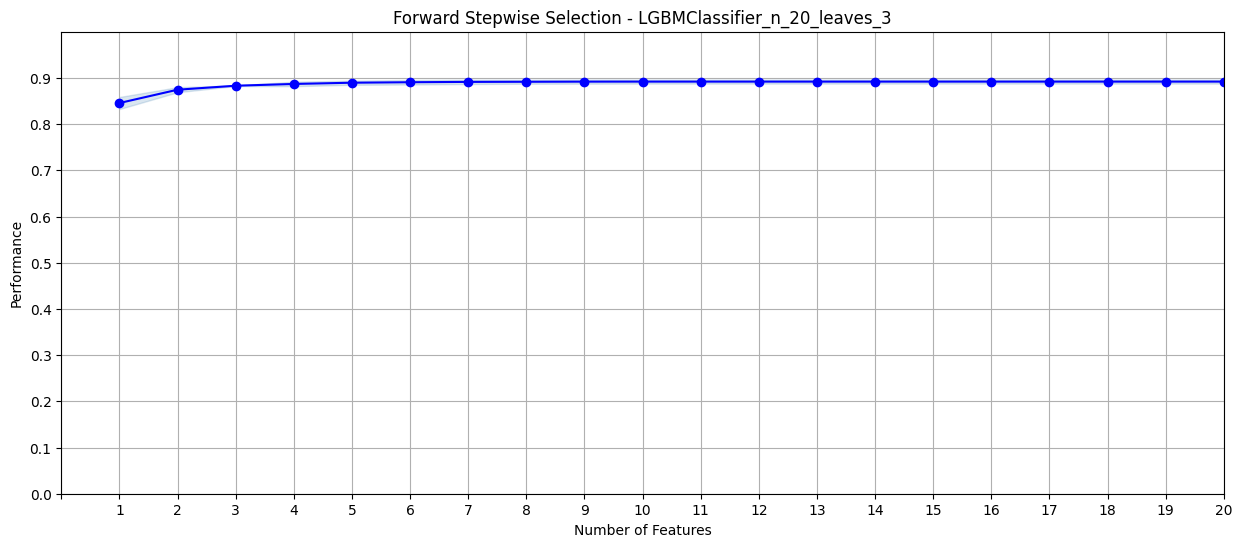

CPU times: user 7.51 s, sys: 670 ms, total: 8.18 s
Wall time: 2min 20s


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(1,)","[0.86255858836504, 0.8436379928315413, 0.83074...",0.845646,"(med_bef_count,)",0.029404,0.013067,0.009239,1.0,med_bef_count
2,"(1, 10)","[0.8820995312930797, 0.8694513371932726, 0.871...",0.874483,"(med_bef_count, med_bef_ade_diagnosis)",0.012326,0.005477,0.003873,2.0,med_bef_ade_diagnosis
3,"(1, 10, 62)","[0.8831679073614558, 0.883857182244279, 0.8823...",0.88312,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.001401,0.000622,0.00044,3.0,med_af_ade_diagnosis
4,"(1, 10, 42, 62)","[0.8938516680452164, 0.8837882547559968, 0.883...",0.886946,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.011002,0.004889,0.003457,4.0,med_af_pdc_count_C79_percent-med_bef_pdc_count...
5,"(1, 10, 42, 57, 62)","[0.8946443341604633, 0.8903708298869589, 0.883...",0.889612,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.010017,0.004451,0.003148,5.0,rx_af_count-rx_bef_count
6,"(1, 10, 42, 57, 62, 120)","[0.8946443341604633, 0.8936104218362284, 0.883...",0.890692,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.010975,0.004877,0.003449,6.0,med_af_pdc_count_I/med_af_count
7,"(1, 10, 42, 57, 62, 98, 120)","[0.8956093189964158, 0.8936104218362284, 0.884...",0.891394,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.010399,0.004621,0.003268,7.0,med_af_diarrhea_diagnosis_percent-med_bef_diar...
8,"(1, 10, 42, 57, 62, 71, 98, 120)","[0.8956093189964158, 0.8936104218362284, 0.885...",0.89167,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.009534,0.004237,0.002996,8.0,med_bef_constipation_diagnosis
9,"(1, 10, 42, 56, 57, 62, 71, 98, 120)","[0.8956093189964158, 0.8944375516956162, 0.885...",0.891946,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.009854,0.004379,0.003096,9.0,med_bef_nausea_diagnosis
10,"(1, 10, 42, 56, 57, 62, 71, 78, 98, 120)","[0.8956093189964158, 0.8944375516956162, 0.886...",0.892026,"(med_bef_count, med_bef_ade_diagnosis, med_af_...",0.009599,0.004265,0.003016,10.0,med_bef_pdc_count_K/med_bef_count


In [ ]:
%%time
sfs_forward_LGBM_20_3 = wrapper_execution(algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                                          title = 'Forward Stepwise Selection - LGBMClassifier_n_20_leaves_3',
                                          filename = 'wrapper_LGBMClassifier_n_20_leaves_3_forward_10',
                                          num_wrapper=20,
                                          forward_flag=True)
sfs_forward_LGBM_20_3[1]

### 2.2 Race 0

In [ ]:
race_0 = target_train_cc.query("race_cd == 0").index
race_1 = target_train_cc.query("race_cd == 1").index
race_2 = target_train_cc.query("race_cd == 2").index
race_3 = target_train_cc.query("race_cd == 3").index
race_4 = target_train_cc.query("race_cd == 4").index
race_5 = target_train_cc.query("race_cd == 5").index
# race_6 = target_train_cc.query("race_cd == 6").index # Skip this cuz too few people

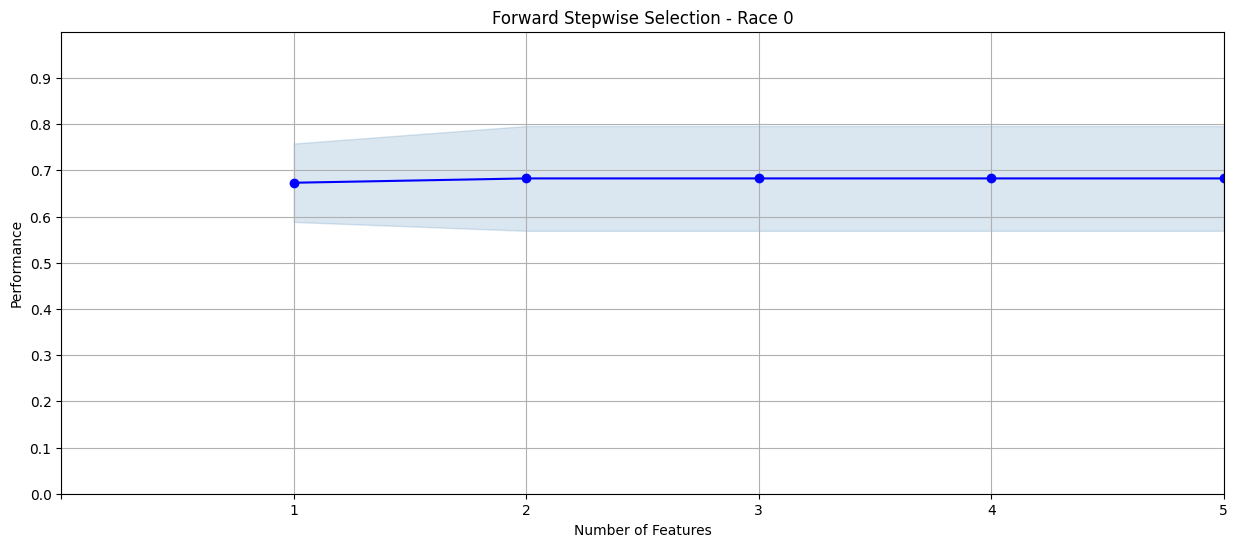

CPU times: user 2.55 s, sys: 148 ms, total: 2.7 s
Wall time: 30 s


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(60,)","[0.6442307692307692, 0.7884615384615384, 0.586...",0.67312,"(rx_bef_cost_per_claim,)",0.191002,0.084877,0.060017,1.0,rx_bef_cost_per_claim
2,"(57, 60)","[0.6442307692307692, 0.8365384615384616, 0.566...",0.682479,"(rx_af_count-rx_bef_count, rx_bef_cost_per_claim)",0.25529,0.113446,0.080218,2.0,rx_af_count-rx_bef_count
3,"(0, 57, 60)","[0.6442307692307692, 0.8365384615384616, 0.566...",0.682479,"(med_bef_pdc_count_C/med_bef_count, rx_af_coun...",0.25529,0.113446,0.080218,3.0,med_bef_pdc_count_C/med_bef_count
4,"(0, 1, 57, 60)","[0.6442307692307692, 0.8365384615384616, 0.566...",0.682479,"(med_bef_pdc_count_C/med_bef_count, med_bef_co...",0.25529,0.113446,0.080218,4.0,med_bef_count
5,"(0, 1, 2, 57, 60)","[0.6442307692307692, 0.8365384615384616, 0.566...",0.682479,"(med_bef_pdc_count_C/med_bef_count, med_bef_co...",0.25529,0.113446,0.080218,5.0,med_bef_pdc_count_C


In [ ]:
%%time
sfs_ROC_race_0 = wrapper_execution(X = X_wrapper.iloc[race_0, :], y = y_wrapper[race_0],
                                   algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                                   title = 'Forward Stepwise Selection - Race 0',
                                   filename = 'wrapper_race_0',
                                   num_wrapper = 5)
sfs_ROC_race_0[1]

### 2.4 Race 2

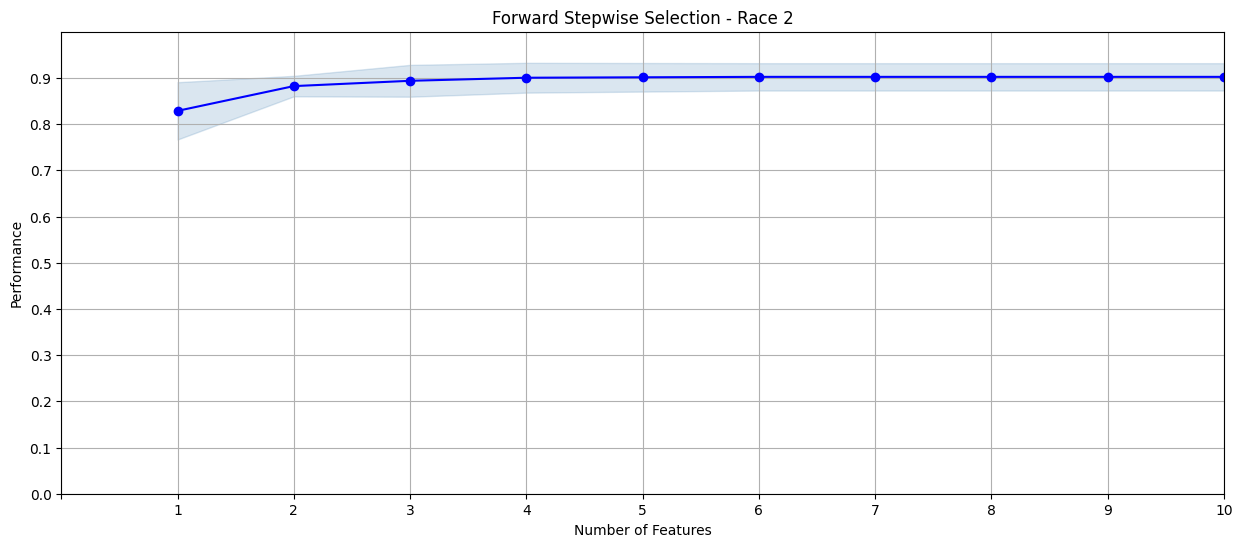

CPU times: user 4.05 s, sys: 366 ms, total: 4.42 s
Wall time: 48.2 s


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(8,)","[0.7681818181818182, 0.8039772727272727, 0.913...",0.828704,"(med_bef_pdc_count_Z/med_bef_count,)",0.13958,0.062026,0.043859,1.0,med_bef_pdc_count_Z/med_bef_count
2,"(8, 13)","[0.8772727272727273, 0.8579545454545454, 0.911...",0.882285,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.04995,0.022197,0.015696,2.0,med_length_therapy
3,"(8, 13, 27)","[0.9068181818181819, 0.8465909090909091, 0.927...",0.893772,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.077535,0.034455,0.024363,3.0,med_af_pdc_count_C/med_all_pdc_count_C
4,"(8, 13, 17, 27)","[0.9181818181818182, 0.8551136363636364, 0.927...",0.900401,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.072614,0.032268,0.022817,4.0,med_bef_pdc_count_I
5,"(8, 13, 17, 27, 135)","[0.9181818181818182, 0.8579545454545454, 0.927...",0.901348,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.069624,0.030939,0.021877,5.0,rx_af_anticoag_ind_percent-rx_bef_anticoag_ind...
6,"(8, 13, 17, 27, 45, 135)","[0.9181818181818182, 0.8607954545454546, 0.927...",0.902295,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.066636,0.029612,0.020939,6.0,med_bef_pdc_count_E/med_bef_count
7,"(8, 13, 17, 27, 28, 45, 135)","[0.9181818181818182, 0.8607954545454546, 0.927...",0.902295,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.066636,0.029612,0.020939,7.0,med_af_pdc_count_C
8,"(8, 13, 17, 27, 28, 31, 45, 135)","[0.9181818181818182, 0.8607954545454546, 0.927...",0.902295,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.066636,0.029612,0.020939,8.0,med_bef_fatigue_diagnosis/med_bef_count
9,"(8, 13, 17, 27, 28, 31, 32, 45, 135)","[0.9181818181818182, 0.8607954545454546, 0.927...",0.902295,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.066636,0.029612,0.020939,9.0,med_bef_fatigue_diagnosis
10,"(8, 13, 17, 27, 28, 31, 32, 38, 45, 135)","[0.9181818181818182, 0.8607954545454546, 0.927...",0.902295,"(med_bef_pdc_count_Z/med_bef_count, med_length...",0.066636,0.029612,0.020939,10.0,med_af_non_serious


In [ ]:
%%time
sfs_ROC_race_2 = wrapper_execution(X = X_wrapper.iloc[race_2, :], y = y_wrapper[race_2],
                                   algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                                   title = 'Forward Stepwise Selection - Race 2',
                                   filename = 'wrapper_race_2',
                                   num_wrapper = 10,
                                   forward_flag=True)
sfs_ROC_race_2[1]

### 2.4 Race 3

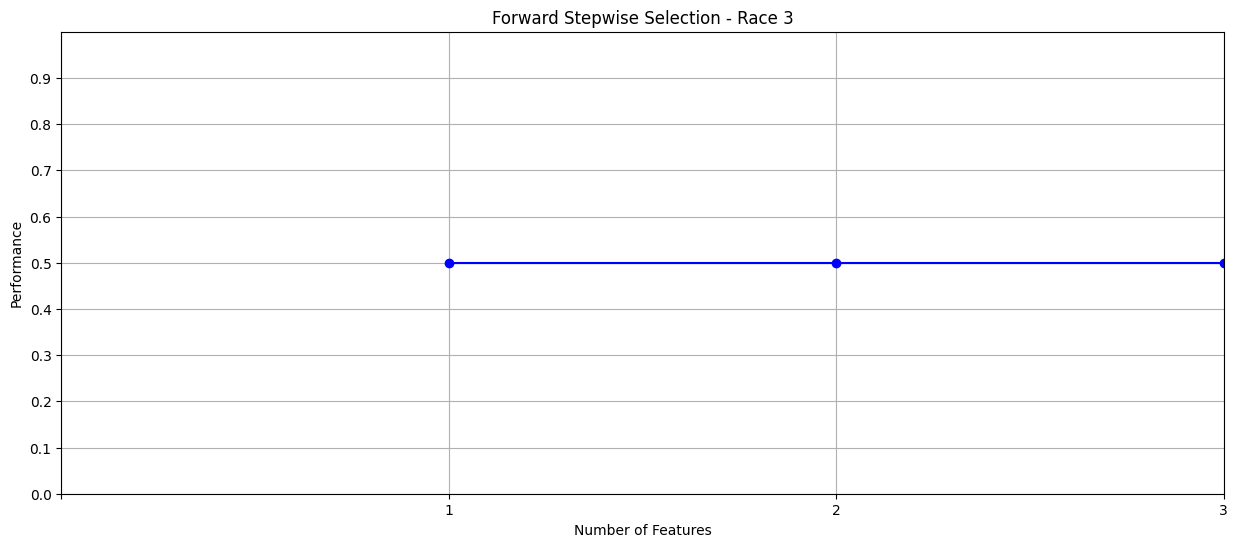

CPU times: user 1.62 s, sys: 148 ms, total: 1.77 s
Wall time: 16.8 s


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(0,)","[0.5, 0.5, 0.5]",0.5,"(med_bef_pdc_count_C/med_bef_count,)",0.0,0.0,0.0,1.0,med_bef_pdc_count_C/med_bef_count
2,"(0, 1)","[0.5, 0.5, 0.5]",0.5,"(med_bef_pdc_count_C/med_bef_count, med_bef_co...",0.0,0.0,0.0,2.0,med_bef_count
3,"(0, 1, 2)","[0.5, 0.5, 0.5]",0.5,"(med_bef_pdc_count_C/med_bef_count, med_bef_co...",0.0,0.0,0.0,3.0,med_bef_pdc_count_C


In [ ]:
%%time
sfs_ROC_race_3 = wrapper_execution(X = X_wrapper.iloc[race_3, :], y = y_wrapper[race_3],
                                   algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                                   title = 'Forward Stepwise Selection - Race 3',
                                   filename = 'wrapper_race_3',
                                   num_wrapper = 3,
                                   forward_flag=True)
sfs_ROC_race_3[1]

### 2.5 Race 4

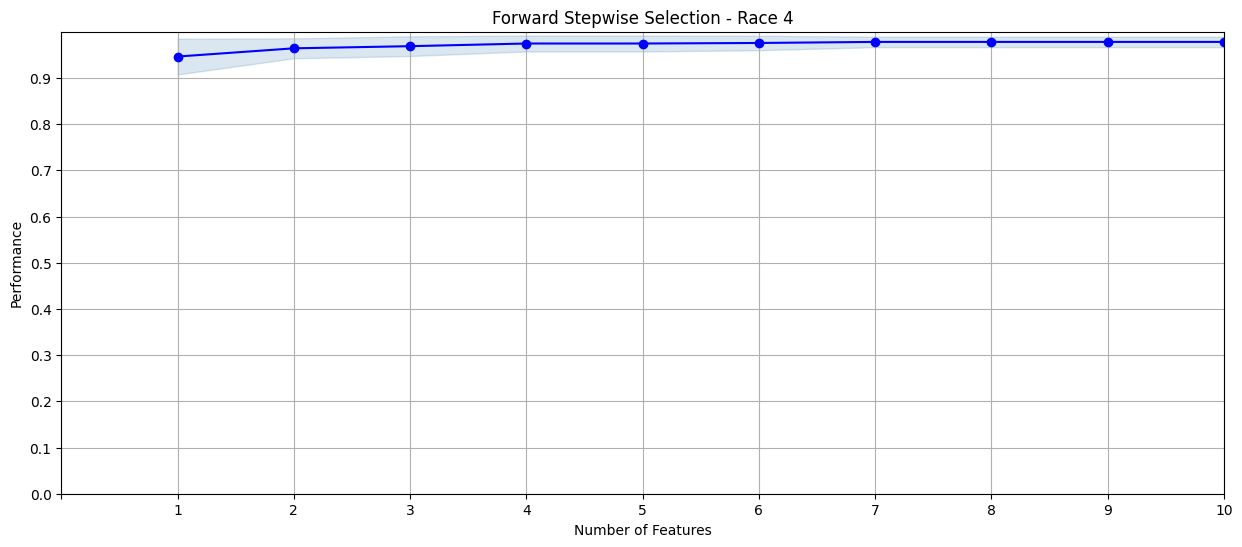

CPU times: user 3.9 s, sys: 239 ms, total: 4.14 s
Wall time: 51.7 s


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(5,)","[1.0, 0.9097222222222222, 0.9290780141843973]",0.946267,"(med_bef_pdc_count_C34/med_bef_count,)",0.087331,0.038808,0.027442,1.0,med_bef_pdc_count_C34/med_bef_count
2,"(5, 58)","[0.9583333333333333, 0.9409722222222222, 0.992...",0.964071,"(med_bef_pdc_count_C34/med_bef_count, rx_bef_c...",0.048579,0.021587,0.015265,2.0,rx_bef_count
3,"(5, 11, 58)","[0.9722222222222222, 0.9409722222222222, 0.992...",0.968701,"(med_bef_pdc_count_C34/med_bef_count, med_bef_...",0.048041,0.021348,0.015096,3.0,med_bef_pdc_count_R
4,"(2, 5, 11, 58)","[0.9791666666666667, 0.9513888888888888, 0.992...",0.974488,"(med_bef_pdc_count_C, med_bef_pdc_count_C34/me...",0.038863,0.01727,0.012212,4.0,med_bef_pdc_count_C
5,"(2, 5, 11, 58, 99)","[0.9791666666666667, 0.951388888888889, 0.9929...",0.974488,"(med_bef_pdc_count_C, med_bef_pdc_count_C34/me...",0.038863,0.01727,0.012212,5.0,rx_af_count/rx_all_count
6,"(0, 2, 5, 11, 58, 99)","[0.9791666666666666, 0.954861111111111, 0.9929...",0.975645,"(med_bef_pdc_count_C/med_bef_count, med_bef_pd...",0.0354,0.015731,0.011123,6.0,med_bef_pdc_count_C/med_bef_count
7,"(0, 2, 3, 5, 11, 58, 99)","[0.9756944444444444, 0.9652777777777778, 0.992...",0.97796,"(med_bef_pdc_count_C/med_bef_count, med_bef_pd...",0.025638,0.011393,0.008056,7.0,med_bef_non_serious/med_bef_count
8,"(0, 2, 3, 5, 7, 11, 58, 99)","[0.9756944444444444, 0.9652777777777778, 0.992...",0.97796,"(med_bef_pdc_count_C/med_bef_count, med_bef_pd...",0.025638,0.011393,0.008056,8.0,med_bef_pdc_count_Z
9,"(0, 2, 3, 5, 7, 8, 11, 58, 99)","[0.9756944444444444, 0.9652777777777778, 0.992...",0.97796,"(med_bef_pdc_count_C/med_bef_count, med_bef_pd...",0.025638,0.011393,0.008056,9.0,med_bef_pdc_count_Z/med_bef_count
10,"(0, 2, 3, 5, 7, 8, 9, 11, 58, 99)","[0.9756944444444444, 0.9652777777777778, 0.992...",0.97796,"(med_bef_pdc_count_C/med_bef_count, med_bef_pd...",0.025638,0.011393,0.008056,10.0,med_bef_ade_diagnosis/med_bef_count


In [ ]:
%%time
sfs_ROC_race_4 = wrapper_execution(X = X_wrapper.iloc[race_4, :], y = y_wrapper[race_4],
                                   algorithm = LGBMClassifier(n_estimators=20, num_leaves=3),
                                   title = 'Forward Stepwise Selection - Race 4',
                                   filename = 'wrapper_race_4',
                                   num_wrapper = 10,
                                   forward_flag=True)
sfs_ROC_race_4[1]

# Classification Model

## 0. Function & Preparation

### varlist

In [ ]:
race_0 = target_train_cc.query("race_cd == 0").index
race_1 = target_train_cc.query("race_cd == 1").index
race_2 = target_train_cc.query("race_cd == 2").index
race_3 = target_train_cc.query("race_cd == 3").index
race_4 = target_train_cc.query("race_cd == 4").index
race_5 = target_train_cc.query("race_cd == 5").index
# race_6 = target_train_cc.query("race_cd == 6").index # Skip this cuz too few people

In [ ]:
try:
    ordered_vars_FS = sfs_forward_LGBM_20_3[1].query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
    ordered_vars_race_0 = sfs_ROC_race_0[1].query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
    ordered_vars_race_2 = sfs_ROC_race_2[1].query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
    ordered_vars_race_4 = sfs_ROC_race_4[1].query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
except:
    ordered_vars_FS = pd.read_csv('wrapper/wrapper_LGBMClassifier_n_20_leaves_3_forward_10.csv').query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
    ordered_vars_race_0 = pd.read_csv('wrapper/wrapper_race_0.csv').query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
    ordered_vars_race_2 = pd.read_csv('wrapper/wrapper_race_2.csv').query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")
    ordered_vars_race_4 = pd.read_csv('wrapper/wrapper_race_4.csv').query("avg_score > avg_score.shift(1) | avg_score.shift(1).isna()")

vars_keep_list = pd.concat([ordered_vars_FS["variable name"],
                            ordered_vars_race_0["variable name"],
                            ordered_vars_race_2["variable name"],
                            ordered_vars_race_4["variable name"]]).drop_duplicates().tolist()

vars_keep_list

['med_bef_count',
 'med_bef_ade_diagnosis',
 'med_af_ade_diagnosis',
 'med_af_pdc_count_C79_percent-med_bef_pdc_count_C79_percent',
 'rx_af_count-rx_bef_count',
 'med_af_pdc_count_I/med_af_count',
 'med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent',
 'med_bef_constipation_diagnosis',
 'med_bef_nausea_diagnosis',
 'med_bef_pdc_count_K/med_bef_count',
 'rx_bef_cost_per_claim',
 'med_bef_pdc_count_Z/med_bef_count',
 'med_length_therapy',
 'med_af_pdc_count_C/med_all_pdc_count_C',
 'med_bef_pdc_count_I',
 'rx_af_anticoag_ind_percent-rx_bef_anticoag_ind_percent',
 'med_bef_pdc_count_E/med_bef_count',
 'med_bef_pdc_count_C34/med_bef_count',
 'rx_bef_count',
 'med_bef_pdc_count_R',
 'med_bef_pdc_count_C',
 'rx_af_count/rx_all_count',
 'med_bef_pdc_count_C/med_bef_count',
 'med_bef_non_serious/med_bef_count']

### model

In [ ]:
X_model = X_all.loc[:, vars_keep_list]
y_model = y_all

In [ ]:
def classification_model_with_auc(X_cls = X_model, y_cls = y_model, model = LogisticRegression(),
                                  kfolds_classification = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True),
                                  race_cd = target_train_cc["race_cd"], sex_cd = target_train_cc["sex_cd"]):

    list_train_accuracy = []
    list_train_precision = []
    list_train_recall = []
    list_train_ks = []
    list_train_auc = []

    list_cv_accuracy = []
    list_cv_precision = []
    list_cv_recall = []
    list_cv_ks = []
    list_cv_auc = []

    # X_cls = X_model.join(race_cd).join(sex_cd)

    for train_index, test_index in kfolds_classification.split(X_cls, y_cls):

        # train set
        X_train = X_cls.iloc[train_index, :]
        y_train = y_cls.iloc[train_index]

        # test set
        X_test = X_cls.iloc[test_index, :]
        y_test = y_cls.iloc[test_index]

        # train the logistic model
        model.fit(X_train, y_train)

    #############################################################################################################################
    # Compute performance e.g. accuracy, precision, recall, AUC, KS
    #############################################################################################################################

        def compute_performance(X, y,
                                list_accuracy, list_precision, list_recall,
                                list_ks, list_auc):

            # compute the probabilities of test data
            y_prob = model.predict_proba(X)[:,1]
            y_pred = model.predict(X)

            # Accuracy
            accuracy = (y==y_pred).sum() / len(y)
            list_accuracy.append(np.round(accuracy, 4))

            # Precision
            precision = ((y_pred + y)==2).sum() / y_pred.sum()
            list_precision.append(np.round(precision, 4))

            # Recall
            recall = ((y_pred + y)==2).sum() / y.sum()
            list_recall.append(np.round(recall, 4))

            # calculate KS and AUC
            # Unite both visions to be able to filter
            df = pd.DataFrame()
            df['real'] = y
            df['proba'] = y_prob

            # Recover each class
            class0 = df[df['real'] == 0]
            class1 = df[df['real'] == 1]

            ks = ks_2samp(class0['proba'], class1['proba'])
            list_ks.append(np.round(ks.statistic, 4)) # I skip ks.pvalue

            roc_auc = roc_auc_score(df['real'] , df['proba'])
            list_auc.append(np.round(roc_auc, 4))

        compute_performance(X_train, y_train,
                            list_train_accuracy, list_train_precision, list_train_recall, list_train_ks, list_train_auc)
        compute_performance(X_test, y_test,
                            list_cv_accuracy, list_cv_precision, list_cv_recall, list_cv_ks, list_cv_auc)

    #############################################################################################################################
    # Printing
    #############################################################################################################################

    print("Accuracy using 10-fold CV:\n{}\n{}".format(list_train_accuracy, list_cv_accuracy))
    print("Mean of accuracy using 10-fold CV: {:.4} and {:.4}\n".format(np.mean(list_train_accuracy), np.mean(list_cv_accuracy)))

    print("Precision using 10-fold CV:\n{}\n{}".format(list_train_precision, list_cv_precision))
    print("Mean of precision using 10-fold CV: {:.4} and {:.4}\n".format(np.mean(list_train_precision), np.mean(list_cv_precision)))

    print("Recall using 10-fold CV:\n{}\n{}".format(list_train_recall, list_cv_recall))
    print("Mean of recall using 10-fold CV: {:.4} and {:.4}\n".format(np.mean(list_train_recall), np.mean(list_cv_recall)))

    print("KS using 10-fold CV:\n{}\n{}".format(list_train_ks, list_cv_ks))
    print("Mean of KS using 10-fold CV: {:.4} and {:.4}\n".format(np.mean(list_train_ks), np.mean(list_cv_ks)))

    print("AUC using 10-fold CV:\n{}\n{}".format(list_train_auc, list_cv_auc))
    print('\033[1m' + "Mean of AUC using 10-fold CV: {:.4} and {:.4}\n".format(np.mean(list_train_auc), np.mean(list_cv_auc)) + '\033[0m')

    #############################################################################################################################
    # Disparity Score
    #############################################################################################################################

    full_model = model.fit(X_cls, y_cls) # fit with all data
    y_pred = full_model.predict(X_cls)

    disparity_df = pd.DataFrame({"race_cd": race_cd,
                                 "sex_cd": sex_cd,
                                 "count": 1,
                                 "tgt_ade_dc_ind": y_cls,
                                 "prediction": y_pred})

    disparity_df["true_positive"] = ((disparity_df["tgt_ade_dc_ind"] == 1) & (disparity_df["prediction"] == 1)).astype(int)

    disparity_race = disparity_df.groupby("race_cd").sum(numeric_only=True).query("race_cd <= 5")
    disparity_race["tpr"] = disparity_race["true_positive"] / disparity_race["tgt_ade_dc_ind"] # True Positive Rate is the same as Recall
    try:
        disparity_race["DR"] = (disparity_race["tpr"] / disparity_race["tpr"][1.0]).apply(lambda DR: 1 if DR > 1 else DR)
    except:
        disparity_race["DR"] = (disparity_race["tpr"] / disparity_race["tpr"].max()).apply(lambda DR: 1 if DR > 1 else DR)
    print(disparity_race, end="\n\n")

    disparity_sex = disparity_df.groupby("sex_cd").sum(numeric_only=True).drop("race_cd", axis=1)
    disparity_sex["tpr"] = disparity_sex["true_positive"] / disparity_sex["tgt_ade_dc_ind"]
    try:
        disparity_sex["DR"] = (disparity_sex["tpr"] / disparity_sex["tpr"]["M"]).apply(lambda DR: 1 if DR > 1 else DR)
    except:
        disparity_sex["DR"] = (disparity_sex["tpr"] / disparity_sex["tpr"].max()).apply(lambda DR: 1 if DR > 1 else DR)
    print(disparity_sex, end="\n\n")

    print('\033[1m' + "Disparity Rate: {:.4} from \nRace: {:.4} \nSex: {:.4}".format(np.append(disparity_race["DR"].to_numpy(),disparity_sex["DR"].to_numpy()).mean(),
                                                                                       disparity_race["DR"].mean(),
                                                                                       disparity_sex["DR"].mean()) + '\033[0m')

    # Percent Positive
    # percent_pos_train = sum(np.round(actual_train)) / len(actual_train)
    # print(f"percent_true from X_train: {percent_true_train} (real)")

    # percent_pos_test = sum(np.round(actual_test)) / len(actual_test)
    # print(f"percent_true from X_test: {percent_true_test} (real)")

    # percent_pos_holdout = sum(np.round(predictions_out[:,1])) / len(predictions_out[:,1])
    # estimated_true_positive = percent_true_out * precision_test
    # print(f"percent_true from X_out: {percent_true_out} (predicted)")
    # print(f"estimated_true_positive: {estimated_true_positive} (w/ prediction_precision from X_test)")

    return model.fit(X_cls, y_cls) # fit with all data

## 1. Logistic Regression

In [ ]:
# log_model = classification_model_with_auc(model = LogisticRegression())

# log_model.coef_

## 2. Decision Tree

### all

In [ ]:
# help(DecisionTreeClassifier) class_weight "balanced" ccp_alpha

In [ ]:
X_tree_cls = target_train_07d.loc[:, vars_keep_list]
y_tree_cls = target_train_cc["tgt_ade_dc_ind"][X_tree_cls.index]

tree_cls_model = classification_model_with_auc(X_cls = X_tree_cls, y_cls = y_tree_cls,
                                               model = DecisionTreeClassifier(min_samples_leaf = 20, max_depth=3, min_impurity_decrease=0.002,
                                                                              random_state=42))

Accuracy using 10-fold CV:
[0.9137, 0.9208, 0.9138, 0.9168, 0.9168]
[0.9231, 0.8947, 0.8902, 0.9106, 0.9106]
Mean of accuracy using 10-fold CV: 0.9164 and 0.9058

Precision using 10-fold CV:
[0.7, 0.8571, 0.6286, 0.65, 0.8]
[1.0, 0.25, 0.0, 0.5556, 0.6]
Mean of precision using 10-fold CV: 0.7271 and 0.4811

Recall using 10-fold CV:
[0.1505, 0.1935, 0.234, 0.2766, 0.1702]
[0.2083, 0.0417, 0.0, 0.2174, 0.1304]
Mean of recall using 10-fold CV: 0.205 and 0.1196

KS using 10-fold CV:
[0.6364, 0.6577, 0.6273, 0.6295, 0.6564]
[0.6534, 0.549, 0.6292, 0.5902, 0.5722]
Mean of KS using 10-fold CV: 0.6415 and 0.5988

AUC using 10-fold CV:
[0.8841, 0.8903, 0.8914, 0.8866, 0.8964]
[0.8836, 0.8019, 0.8552, 0.8433, 0.826]
Mean of AUC using 10-fold CV: 0.8898 and 0.842

         count  tgt_ade_dc_ind  prediction  true_positive       tpr   DR
race_cd                                                                 
0.0         84               7           2              2  0.285714  1.0
1.0        699   

In [ ]:
print(tree.export_text(tree_cls_model, feature_names = list(X_tree_cls.columns), show_weights=True))

|--- med_bef_ade_diagnosis <= 1.50
|   |--- med_bef_pdc_count_C/med_bef_count <= 0.20
|   |   |--- weights: [761.00, 5.00] class: 0
|   |--- med_bef_pdc_count_C/med_bef_count >  0.20
|   |   |--- med_bef_count <= 57.50
|   |   |   |--- weights: [242.00, 37.00] class: 0
|   |   |--- med_bef_count >  57.50
|   |   |   |--- weights: [19.00, 11.00] class: 0
|--- med_bef_ade_diagnosis >  1.50
|   |--- med_af_ade_diagnosis <= 0.50
|   |   |--- weights: [87.00, 45.00] class: 0
|   |--- med_af_ade_diagnosis >  0.50
|   |   |--- weights: [6.00, 19.00] class: 1



In [ ]:
pd.set_option('display.float_format', '{:.4f}'.format)

explore = target_train_07d.copy().drop(list(all_var_list), axis=1)

explore["med_bef_ade_diagnosis <= 1"] = explore["med_bef_ade_diagnosis"] <= 1
explore["med_bef_count > 0"] = explore["med_bef_count"] > 0

print(explore.groupby(["med_bef_count > 0", "med_bef_ade_diagnosis <= 1"]).size())

(explore.groupby(["med_bef_count > 0", "med_bef_ade_diagnosis <= 1"]).mean().T
 .to_csv("exploration/med_bef_count and med_bef_ade_diagnosis.csv"))

explore.groupby(["med_bef_count > 0", "med_bef_ade_diagnosis <= 1"]).mean().T

med_bef_count > 0  med_bef_ade_diagnosis <= 1
False              True                          721
True               False                         157
                   True                          354
dtype: int64


The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


med_bef_count > 0                    False           True                 
med_bef_ade_diagnosis <= 1           True            False           True 
id                         1072170399.5756 1060854244.0764 1066676170.8898
tgt_ade_dc_ind                      0.0028          0.4076          0.1441
race_cd                             1.7363          1.5924          1.5926
est_age                            73.6209         73.6928         74.1148
cms_disabled_ind                    0.0999          0.1720          0.1977
...                                    ...             ...             ...
rx_bef_cost_per_claim            4236.4607       1719.0497       2966.4184
rx_bef_daily_cost                 138.0339         53.0514         87.1313
rx_af_cost_per_claim               83.7173         20.1626         93.8578
rx_af_daily_cost                    3.6632          1.0787          3.0215
rx_length_therapy                   1.6699          1.9427          1.8333

[273 rows x 3 columns]

In [ ]:
explainer = shap.TreeExplainer(tree_cls_model)
shap_values = explainer.shap_values(X_tree_cls)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0:1, :], X_tree_cls.iloc[0:1, :])

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


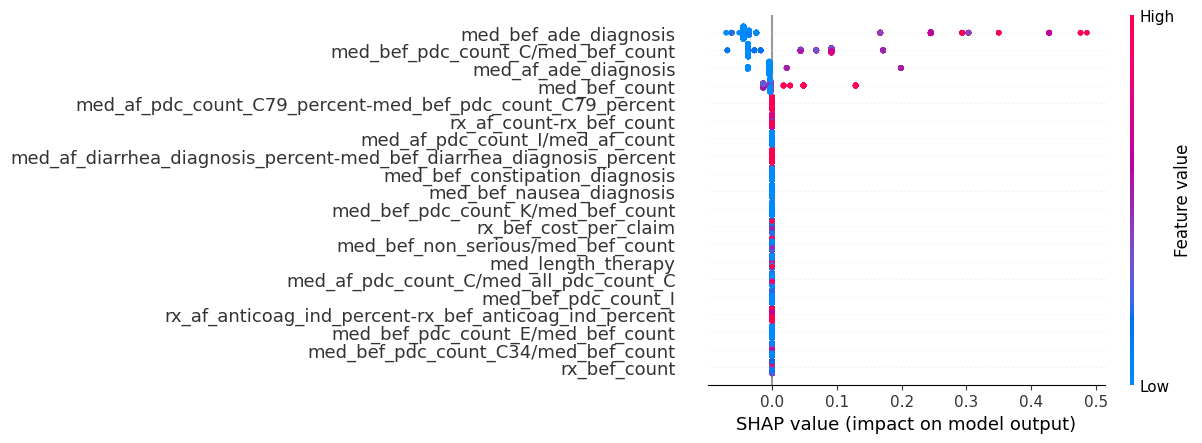

In [ ]:
shap.summary_plot(shap_values[1], X_tree_cls, plot_size = None)

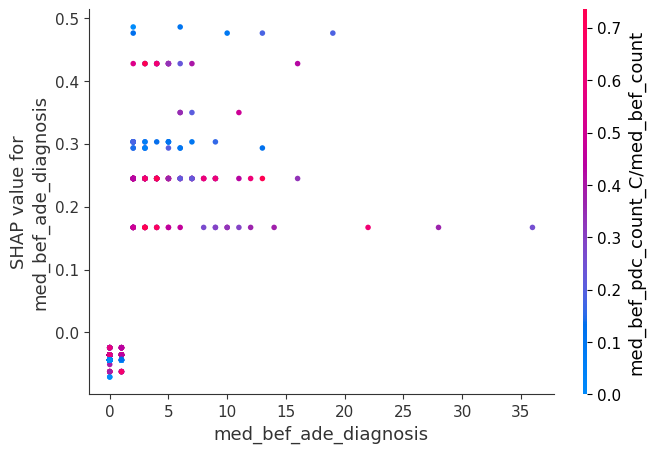

In [ ]:
shap.dependence_plot("med_bef_ade_diagnosis", shap_values[1], X_tree_cls)

Feature 0: med_bef_count, Score: 5.368%
Feature 1: med_bef_ade_diagnosis, Score: 63.638%
Feature 2: med_af_ade_diagnosis, Score: 13.355%
Feature 22: med_bef_pdc_count_C/med_bef_count, Score: 17.639%


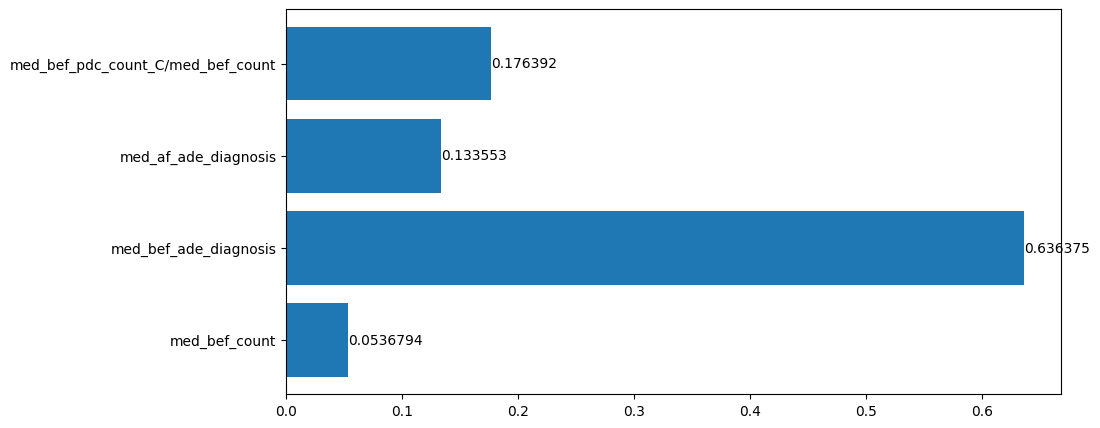

In [ ]:
importance = tree_cls_model.tree_.compute_feature_importances(normalize=True)

colname = []
importance_list = []

# summarize feature importance
for i, v in enumerate(zip(list(X_tree_cls.columns), importance)):
    if v[1] > 0:
        print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
        colname.append(v[0])
        importance_list.append(v[1])

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 5))
fig.set_dpi(100)
bars = ax.barh(colname, importance_list)
ax.bar_label(bars)
plt.show()

### race 4

In [ ]:
rare_race = pd.concat([race_4.to_series()])

tree_cls_model_rare_race = classification_model_with_auc(X_cls = X_tree_cls.iloc[rare_race, :], y_cls = y_tree_cls[rare_race],
                                               race_cd = target_train_cc.loc[rare_race, "race_cd"], sex_cd = target_train_cc.loc[rare_race, "sex_cd"],
                                               model = DecisionTreeClassifier(min_samples_leaf = 10, max_depth=3, min_impurity_decrease=0.0001,
                                                                              random_state=42))

Accuracy using 10-fold CV:
[0.9587, 0.9421, 0.9426, 0.9426, 0.9426]
[0.871, 0.9355, 0.9333, 0.9333, 0.9]
Mean of accuracy using 10-fold CV: 0.9457 and 0.9146

Precision using 10-fold CV:
[0.5833, nan, nan, nan, 0.5333]
[0.3333, nan, nan, nan, 0.25]
Mean of precision using 10-fold CV: nan and nan

Recall using 10-fold CV:
[1.0, 0.0, 0.0, 0.0, 1.0]
[1.0, 0.0, 0.0, 0.0, 1.0]
Mean of recall using 10-fold CV: 0.4 and 0.4

KS using 10-fold CV:
[0.9561, 0.9211, 0.9391, 0.9304, 0.9386]
[0.8621, 1.0, 0.9286, 0.4643, 0.8966]
Mean of KS using 10-fold CV: 0.9371 and 0.8303

AUC using 10-fold CV:
[0.9781, 0.9605, 0.9696, 0.9652, 0.9693]
[0.931, 1.0, 0.9643, 0.7321, 0.9483]
Mean of AUC using 10-fold CV: 0.9685 and 0.9151

         count  tgt_ade_dc_ind  prediction  true_positive    tpr  DR
race_cd                                                             
4.0000     152               9           0              0 0.0000 NaN

        count  tgt_ade_dc_ind  prediction  true_positive    tpr  DR
sex_cd

invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars
invalid value encountered in long_scalars


In [ ]:
print(tree.export_text(tree_cls_model_rare_race, feature_names = list(X_tree_cls.columns), show_weights=True))

|--- med_bef_pdc_count_E/med_bef_count <= 0.02
|   |--- weights: [134.00, 0.00] class: 0
|--- med_bef_pdc_count_E/med_bef_count >  0.02
|   |--- weights: [9.00, 9.00] class: 0



## 3. Random Forest

In [ ]:
X_rf_cls = target_train_07d.loc[:, vars_keep_list]
y_rf_cls = target_train_cc["tgt_ade_dc_ind"][X_rf_cls.index]

rf_cls_model = classification_model_with_auc(X_cls = X_rf_cls, y_cls = y_rf_cls,
                                             model = RandomForestClassifier(min_samples_leaf = 10, max_depth=5,
                                                                             random_state=42))

invalid value encountered in long_scalars
invalid value encountered in long_scalars


Accuracy using 10-fold CV:
[0.9127, 0.9188, 0.9128, 0.9158, 0.9178]
[0.8947, 0.9028, 0.9065, 0.9065, 0.9106]
Mean of accuracy using 10-fold CV: 0.9156 and 0.9042

Precision using 10-fold CV:
[1.0, 0.9333, 0.7857, 0.9231, 1.0]
[0.0, nan, nan, 0.5, 1.0]
Mean of precision using 10-fold CV: 0.9284 and nan

Recall using 10-fold CV:
[0.0753, 0.1505, 0.117, 0.1277, 0.1383]
[0.0, 0.0, 0.0, 0.0435, 0.0435]
Mean of recall using 10-fold CV: 0.1218 and 0.0174

KS using 10-fold CV:
[0.82, 0.8283, 0.7966, 0.8061, 0.8039]
[0.6925, 0.679, 0.7189, 0.7233, 0.7278]
Mean of KS using 10-fold CV: 0.811 and 0.7083

AUC using 10-fold CV:
[0.9552, 0.9561, 0.9512, 0.95, 0.9546]
[0.9023, 0.8694, 0.9138, 0.8879, 0.882]
Mean of AUC using 10-fold CV: 0.9534 and 0.8911

         count  tgt_ade_dc_ind  prediction  true_positive    tpr     DR
race_cd                                                                
0.0000      84               7           3              3 0.4286 1.0000
1.0000     699              74    

In [ ]:
explainer = shap.TreeExplainer(rf_cls_model)
shap_values = explainer.shap_values(X_model)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0:100, :], X_model.iloc[0:100, :])

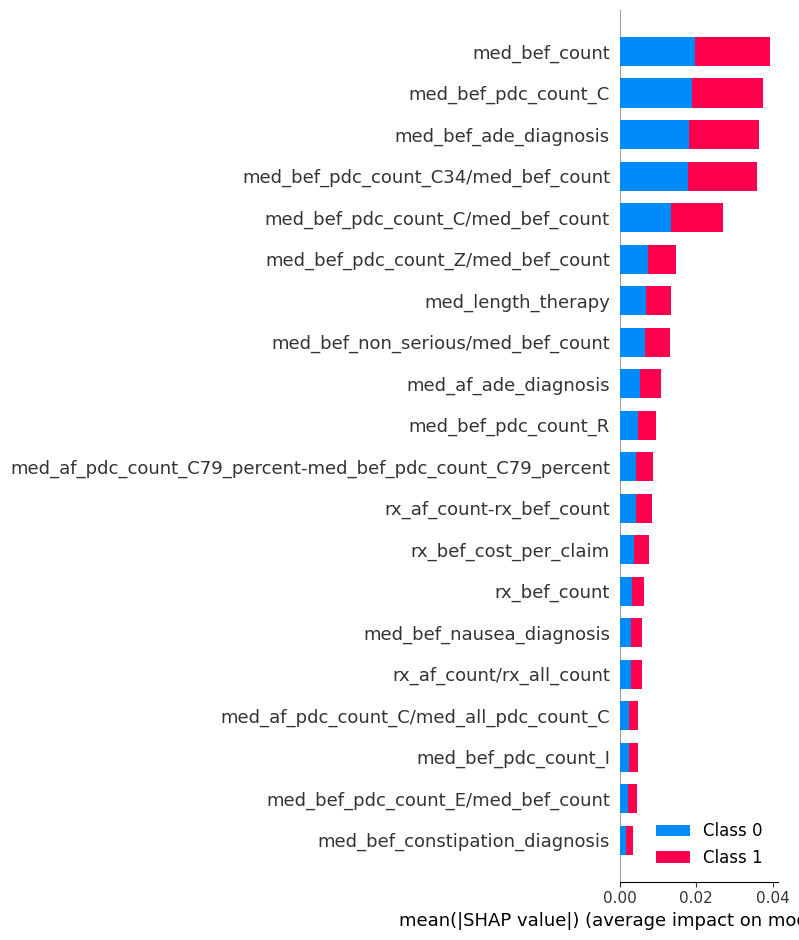

In [ ]:
shap_values = shap.TreeExplainer(rf_cls_model).shap_values(X_model)
shap.summary_plot(shap_values, X_model)

Feature 0: med_bef_count, Score: 10.682%
Feature 1: med_bef_ade_diagnosis, Score: 13.134%
Feature 2: med_af_ade_diagnosis, Score: 5.134%
Feature 3: med_af_pdc_count_C79_percent-med_bef_pdc_count_C79_percent, Score: 2.950%
Feature 4: rx_af_count-rx_bef_count, Score: 3.223%
Feature 5: med_af_pdc_count_I/med_af_count, Score: 0.150%
Feature 6: med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent, Score: 1.268%
Feature 7: med_bef_constipation_diagnosis, Score: 1.629%
Feature 8: med_bef_nausea_diagnosis, Score: 2.136%
Feature 9: med_bef_pdc_count_K/med_bef_count, Score: 0.533%
Feature 10: rx_bef_cost_per_claim, Score: 3.137%
Feature 11: med_bef_pdc_count_Z/med_bef_count, Score: 5.259%
Feature 12: med_length_therapy, Score: 3.301%
Feature 13: med_af_pdc_count_C/med_all_pdc_count_C, Score: 2.253%
Feature 14: med_bef_pdc_count_I, Score: 1.757%
Feature 15: rx_af_anticoag_ind_percent-rx_bef_anticoag_ind_percent, Score: 0.772%
Feature 16: med_bef_pdc_count_E/med_bef_count, Score: 1

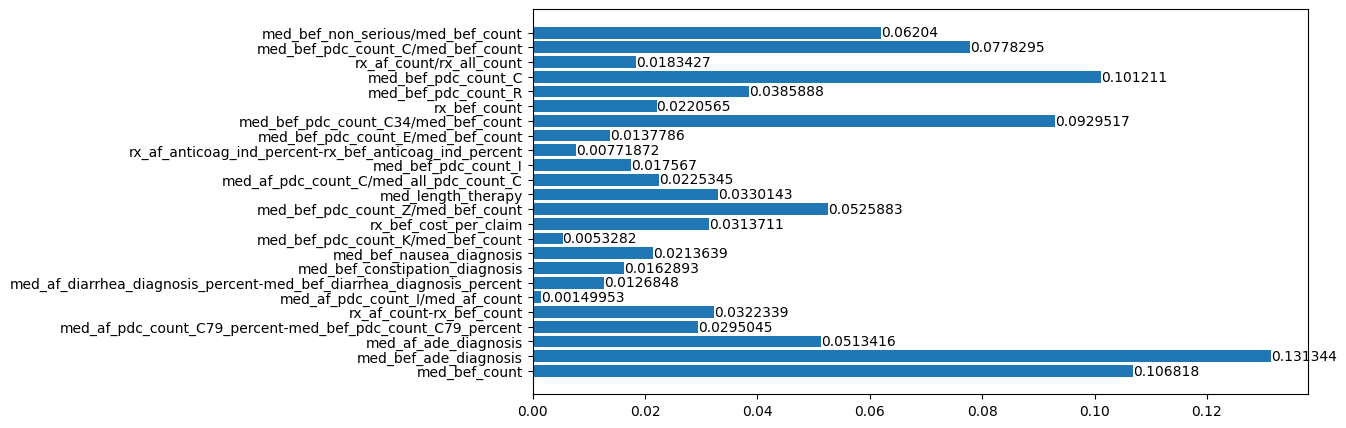

In [ ]:
importance = rf_cls_model.feature_importances_

colname = []
importance_list = []

# summarize feature importance
for i, v in enumerate(zip(list(X_model.columns), importance)):
    if v[1] > 0:
        print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
        colname.append(v[0])
        importance_list.append(v[1])

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 5))
fig.set_dpi(100)
bars = ax.barh(colname, importance_list)
ax.bar_label(bars)
plt.show()

## 4. LGBM

In [ ]:
X_light_cls = target_train_07d.loc[:, vars_keep_list]
y_light_cls = target_train_cc["tgt_ade_dc_ind"][X_rf_cls.index]

light_cls_model = classification_model_with_auc(X_cls = X_light_cls, y_cls = y_light_cls,
                                                model = LGBMClassifier(num_leaves=3,
                                                                    n_estimators=50,
                                                                    random_state=1022,
                                                                    importance_type="gain",
                                                                    verbose = -1))

Accuracy using 10-fold CV:
[0.9239, 0.9249, 0.9229, 0.9239, 0.9219]
[0.915, 0.8907, 0.9065, 0.9065, 0.9065]
Mean of accuracy using 10-fold CV: 0.9235 and 0.905

Precision using 10-fold CV:
[0.95, 0.8276, 0.9091, 0.8519, 0.84]
[0.7143, 0.2857, 0.5, 0.5, 0.5]
Mean of precision using 10-fold CV: 0.8757 and 0.5

Recall using 10-fold CV:
[0.2043, 0.2581, 0.2128, 0.2447, 0.2234]
[0.2083, 0.0833, 0.087, 0.2174, 0.087]
Mean of recall using 10-fold CV: 0.2287 and 0.1366

KS using 10-fold CV:
[0.7702, 0.7458, 0.7669, 0.7557, 0.7691]
[0.6669, 0.679, 0.7247, 0.6682, 0.6637]
Mean of KS using 10-fold CV: 0.7615 and 0.6805

AUC using 10-fold CV:
[0.9383, 0.9438, 0.9389, 0.9383, 0.9407]
[0.9041, 0.8691, 0.924, 0.8867, 0.8547]
Mean of AUC using 10-fold CV: 0.94 and 0.8877

         count  tgt_ade_dc_ind  prediction  true_positive    tpr     DR
race_cd                                                                
0.0000      84               7           3              3 0.4286 1.0000
1.0000     699   

In [ ]:
explainer = shap.TreeExplainer(light_cls_model)
shap_values = explainer.shap_values(X_light_cls)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0:100, :], X_light_cls.iloc[0:100, :])

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


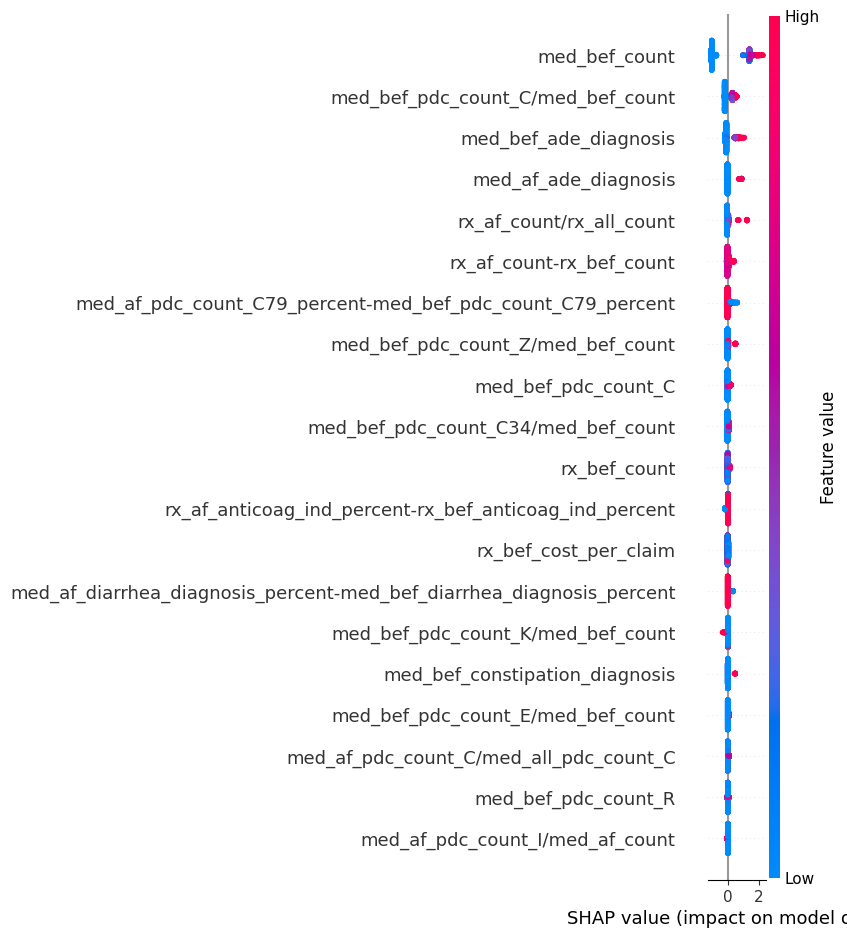

In [ ]:
shap.summary_plot(shap_values[1], X_light_cls)

Feature 0: med_bef_count, Score: 72578.164%
Feature 1: med_bef_ade_diagnosis, Score: 31981.981%
Feature 2: med_af_ade_diagnosis, Score: 10693.047%
Feature 3: med_af_pdc_count_C79_percent-med_bef_pdc_count_C79_percent, Score: 3369.359%
Feature 4: rx_af_count-rx_bef_count, Score: 2836.532%
Feature 5: med_af_pdc_count_I/med_af_count, Score: 483.640%
Feature 6: med_af_diarrhea_diagnosis_percent-med_bef_diarrhea_diagnosis_percent, Score: 1872.344%
Feature 7: med_bef_constipation_diagnosis, Score: 2334.831%
Feature 9: med_bef_pdc_count_K/med_bef_count, Score: 1161.094%
Feature 10: rx_bef_cost_per_claim, Score: 355.505%
Feature 11: med_bef_pdc_count_Z/med_bef_count, Score: 2658.758%
Feature 13: med_af_pdc_count_C/med_all_pdc_count_C, Score: 581.448%
Feature 15: rx_af_anticoag_ind_percent-rx_bef_anticoag_ind_percent, Score: 651.102%
Feature 16: med_bef_pdc_count_E/med_bef_count, Score: 507.120%
Feature 17: med_bef_pdc_count_C34/med_bef_count, Score: 1439.819%
Feature 18: rx_bef_count, Score: 1

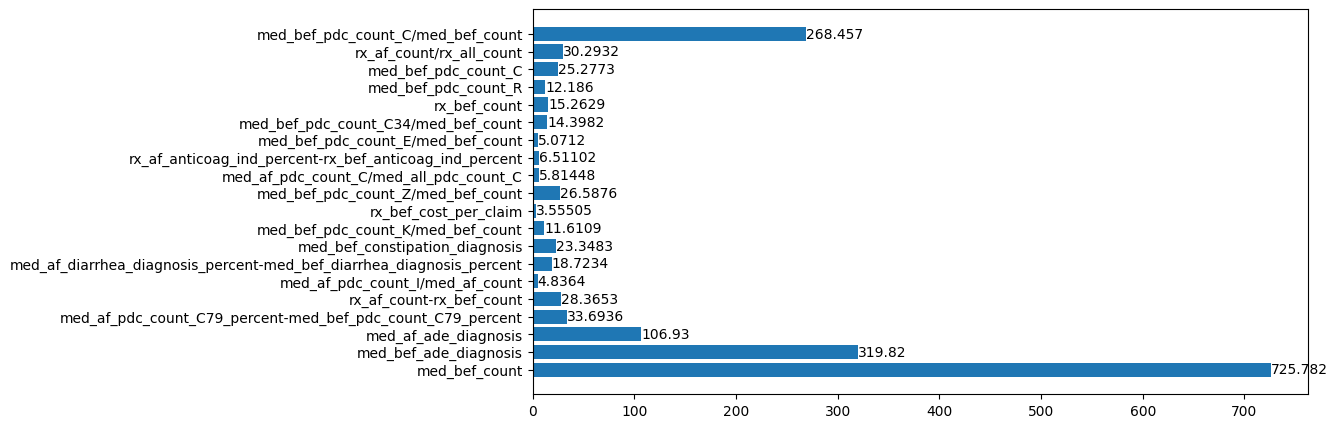

In [ ]:
importance = light_cls_model.feature_importances_

colname = []
importance_list = []

# summarize feature importance
for i, v in enumerate(zip(list(X_light_cls.columns), importance)):
    if v[1] > 0:
        print('Feature {}: {}, Score: {:.3%}'.format(i, v[0], v[1]))
        colname.append(v[0])
        importance_list.append(v[1])

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 5))
fig.set_dpi(100)
bars = ax.barh(colname, importance_list)
ax.bar_label(bars)
plt.show()

In [ ]:
rare_race = pd.concat([race_0.to_series(), race_2.to_series(), race_4.to_series()])
light_cls_model_rare_race = classification_model_with_auc(X_cls = X_light_cls.iloc[rare_race, :], y_cls = target_train_cc["tgt_ade_dc_ind"][rare_race],
                                                    race_cd = target_train_cc.loc[rare_race, "race_cd"], sex_cd = target_train_cc.loc[rare_race, "sex_cd"],
                                                    model = LGBMClassifier(num_leaves=3,
                                                                           n_estimators=50,
                                                                           random_state=1022,
                                                                           importance_type="gain",
                                                                           verbose = -1))

Accuracy using 10-fold CV:
[0.9507, 0.9607, 0.9475, 0.9475, 0.9574]
[0.9221, 0.9079, 0.9211, 0.9211, 0.9079]
Mean of accuracy using 10-fold CV: 0.9528 and 0.916

Precision using 10-fold CV:
[1.0, 0.9286, 1.0, 1.0, 0.9231]
[nan, 0.0, nan, 0.5, 0.3333]
Mean of precision using 10-fold CV: 0.9703 and nan

Recall using 10-fold CV:
[0.375, 0.5417, 0.3333, 0.3333, 0.5]
[0.0, 0.0, 0.0, 0.1667, 0.1667]
Mean of recall using 10-fold CV: 0.4167 and 0.06668

KS using 10-fold CV:
[0.9036, 0.8562, 0.8897, 0.8836, 0.9075]
[0.5915, 0.6571, 0.7143, 0.6857, 0.6571]
Mean of KS using 10-fold CV: 0.8881 and 0.6611

AUC using 10-fold CV:
[0.9826, 0.9788, 0.9771, 0.9818, 0.9838]
[0.7782, 0.8357, 0.8452, 0.8762, 0.819]
Mean of AUC using 10-fold CV: 0.9808 and 0.8309

         count  tgt_ade_dc_ind  prediction  true_positive    tpr     DR
race_cd                                                                
0.0000      84               7           3              3 0.4286 1.0000
2.0000     145              14 

invalid value encountered in long_scalars
invalid value encountered in long_scalars


# Prediction

In [ ]:
X_test_pred = target_test_cc.loc[:, vars_keep_list]

## 1. To CSV

In [ ]:
y_test_prob = light_cls_model.predict_proba(X_test_pred)[:, 1]

In [ ]:
y_test_prob[target_test_cc.query("race_cd == 4").index]

In [ ]:
submission = pd.DataFrame({"ID": target_test_cc["id"], "SCORE": y_test_prob})
submission["RANK"] = submission["SCORE"].rank(ascending=False, method="first").astype(int)

submission = submission.sort_values("RANK", na_position='first')
submission

In [ ]:
submission.to_csv("submission/2023CaseCompetition_Jiayi_Hu_20231006.csv", index = False)

## 2. Ploting

In [ ]:
# train_df_cleaned.plot.scatter('S', 'Value')

In [ ]:
# plt.scatter(test_df['S'], test_value)

In [ ]:
# train_df_cleaned.plot.scatter('K', 'Value')

In [ ]:
# plt.scatter(test_df['K'], test_value)

In [ ]:
# train_df_cleaned.boxplot('S', 'BS_bin')

In [ ]:
# plt.boxplot((test_df['S'][test_BS==0], test_df['S'][test_BS==1]),
#             labels = ["0", "1"])
# plt.show()

In [ ]:
# train_df_cleaned.boxplot('K', 'BS_bin')

In [ ]:
# plt.boxplot((test_df['K'][test_BS==0], test_df['K'][test_BS==1]),
#             labels = ["0", "1"])
# plt.show()

In [ ]:
# target_train_cc[target_train_cc['med_length_therapy'] >= 170]